In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, ttest_rel
from scipy import interpolate
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, mannwhitneyu, wilcoxon, false_discovery_control
import statistics
from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import shapiro, normaltest
from statsmodels.stats import multitest

import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict, KFold

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [59]:
#Plots ROC curve and returns accuracy, precision and recall for a given classification model-
def assess_model(model, X_test, y_test):
    #ROC curve-
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.show()

    y_pred = model.predict(X_test)
    
    print(y_pred, y_test)
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred))
    print("Sensitivity:", metrics.recall_score(y_test, y_pred, pos_label=1))
    print("Specificity:", metrics.recall_score(y_test, y_pred, pos_label=0))
    return()

In [60]:
def fpt2(spectra,n=1):
    #fast phasor transform (fft based) of photon histogram his
    #performs fft along last non-singleton dimension
    #Natzem had a lot of handling for different dimensions but for now I'm just gonna assume one dimension-
    F=np.fft.fft(spectra/np.max(spectra))
    feats=np.concatenate((F[0:5], F[-5:]), axis=0)
    print("feats",abs(feats))
    G=np.fft.ifft(feats)
    xold = np.arange(G.shape[0])
    xnew=np.linspace(0, G.shape[0]-1, num=spectra.shape[0])
    G = np.interp(xnew, xold, G)
    G=G/np.max(G)
    return(G,abs(feats))

In [61]:
#Get indicies for each imaging mode-
def get_indicies(namelist):
    if type(namelist)!=list:
        namelist=namelist.tolist()
    #Adding one to each because they will be used in start:end format
    AFlist = [s for s in namelist if 'ILL' in s]
    if len(AFlist)>0:
        AF_indicies=[namelist.index(AFlist[0]),namelist.index(AFlist[-1])+1]
        print(AF_indicies)
    else:
        AF_indicies=[]
    HSlist=[s for s in namelist if 'HS' in s]
    if len(HSlist)>0:
        HS_indicies=[namelist.index(HSlist[0]),namelist.index(HSlist[-1])+1]
        print(HS_indicies)
    else:
        HS_indicies=[]
    OCTlist=[s for s in namelist if 'OCT' in s]
    if len(OCTlist)>0:
        OCT_indicies=[namelist.index(OCTlist[0]),namelist.index(OCTlist[-1])+1]
        print(OCT_indicies)
    else:
        OCT_indicies=[]
    PLIlist=[s for s in namelist if 'PLI' in s]
    if len(PLIlist)>0:
        PLI_indicies=[namelist.index(PLIlist[0]),namelist.index(PLIlist[-1])+1]
        print(PLI_indicies)
    elif OCT_indicies!=[]:
        PLI_indicies=[OCT_indicies[1],len(namelist)]
        print(PLI_indicies)
    elif HS_indicies!=[]:
        PLI_indicies=[HS_indicies[1],len(namelist)]
        print(PLI_indicies)
    elif AF_indicies!=[]:
        PLI_indicies=[AF_indicies[1],len(namelist)]
        print(PLI_indicies)
    else:
        PLI_indicies=[]
    return(AF_indicies, HS_indicies, OCT_indicies, PLI_indicies)

In [62]:
#Get indicies for a specific type of data- written to isolate HS data from HS ave, etc.
def get_indicies_from_string(namelist, imagingtype, given_string, print_out="no"):
    if type(namelist)!=list:
        namelist=namelist.tolist()
    #Getting Imaging mode list 1st-
    imagingTypeList = [s for s in namelist if imagingtype in s]
    chosenList=[]
    indiciesList=[]
    for name in imagingTypeList:
        letters = ""  # declaring empty string to append
        count = 0  # initializing count to 0
        for char in name:  # looping over every character
            if char.isalpha():  
                count += 1
                letters += char  # appending alphabet character to string
        if given_string==letters:
            chosenList.append(name)
            indiciesList.append(namelist.index(name))
    if print_out!="no":
        print(chosenList)
    return(indiciesList)

In [224]:
#Load in excel file with all samples and feature types-
masterfilepath=r"Q:\BOOM\EsophagealCancerStudy\Data_For_Processing\20250319_NormvsCanc.xlsx"
masterfile_in=np.array(pd.read_excel(masterfilepath, dtype=object, header=None,),dtype=object)

namefile=np.array(pd.read_excel(r"C:\Users\justinamb\OneDrive - University of Arizona\Featurerename2.xlsx", dtype=object, header=None,),dtype=object)
fancynames=namefile[1,:]

#This need to be changed based on what you're running the analysis for to what's on the spreadsheet:
cnamecode='Tumor'

print(masterfile_in.shape)
print(namefile.shape)

print(masterfile_in[:,0])
#Perhaps to start it could be good to go through and assign these values 0 or 1
#Taking patient ID# out as well-
ordered_patID=[]
for i in range(masterfile_in.shape[0]-1):
    ordered_patID.append(int(masterfile_in[i+1,0].split('_')[0]))
    if cnamecode in masterfile_in[i+1,0]:
        masterfile_in[i+1,0]=1
        #Changing to include Barretts in healthy or cancerous, was originally set to 2-
    elif 'Barretts' in masterfile_in[i+1,0]:
        masterfile_in[i+1,0]=2
    else:
        masterfile_in[i+1,0]=0 
print()

#adding some flexibility to the masterarray so we can rerun SS tests after differenct steps in the process-
#For initial run through of code this should be masterfile_in->
Array_in=masterfile_in
#Array_in=Corrarayfrominput

AF_indicies, HS_indicies, OCT_indicies, PLI_indicies = get_indicies(Array_in[0,:])
masterfileindicieslist=[AF_indicies, HS_indicies, OCT_indicies, PLI_indicies]


(35, 675)
(2, 675)
['patID' '255_Normal' '251_Normal' '251_Tumor' '258_Normal' '258_Tumor'
 '259_Normal' '261_Normal' '261_Tumor' '268_Normal' '268_Tumor'
 '270_Normal' '270_Tumor' '271_Normal' '271_Tumor' '273_Tumor' '278_Tumor'
 '280_Normal' '275_Normal' '287_Tumor' '355_Tumor' '349_Normal'
 '364_Normal' '386_Tumor' '388_Normal' '388_Normal' '393_Normal'
 '393_Tumor' '410_Normal' '410_Tumor' '419_Normal' '419_Normal'
 '421_Normal' '421_Normal' '101_Tumor']

[1, 91]
[91, 456]
[456, 505]
[505, 675]


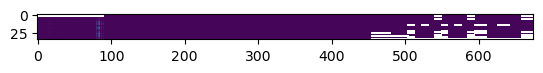

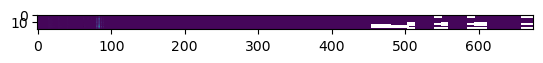

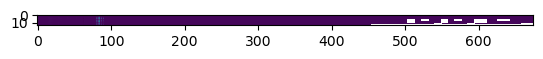

(20, 675) (14, 675) (0,)


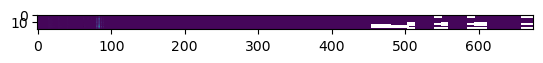

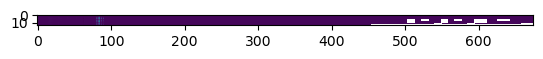

(20, 675) (14, 675) (0,)
(14, 675) (14, 675)
(29, 675)


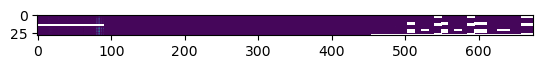

In [226]:
#Orgaize samples by type and format to work with many of the following code->
plt.imshow(np.array(Array_in[1:,:],dtype=float))
plt.show()

Healthy_data=[]
Cancerous_data=[]
Barretts_data=[]

#Assign 0 to healthy samples, 1 to cancerous and 2 to Barretts->
for i in range(Array_in.shape[0]-1):
    if Array_in[i+1,0]==0:
        Healthy_data.append(Array_in[i+1,:])
    elif Array_in[i+1,0]==2:
        Barretts_data.append(Array_in[i+1,:])
    else:
        Cancerous_data.append(Array_in[i+1,:])

Healtharray=np.array(Healthy_data)
Cancarray=np.array(Cancerous_data)
Barrettsarray=np.array(Barretts_data)

plt.imshow(np.array(Healtharray,dtype=float))
plt.show()

plt.imshow(np.array(Cancarray,dtype=float))
plt.show()

# plt.imshow(np.array(Barrettsarray,dtype=float))
# plt.show()

print(Healtharray.shape, Cancarray.shape, Barrettsarray.shape)

healthmeans=np.nanmean(Healtharray, axis=0)
cancmeans=np.nanmean(Cancarray, axis=0)
#barmeans=np.nanmean(Barrettsarray, axis=0)


#*** Handling for missing values- filling in missing vals with means *** ->
# for i in range(Array_in.shape[1]-1):
#     hline=Healtharray[:,i+1]
#     Healtharray[:,i+1]=np.where(np.isnan(hline.astype('float64')),healthmeans[i+1],hline)
    
#     cline=Cancarray[:,i+1]
#     Cancarray[:,i+1]=np.where(np.isnan(cline.astype('float64')),cancmeans[i+1],cline)
    
#     bline=Barrettsarray[:,i+1]
#     Barrettsarray[:,i+1]=np.where(np.isnan(bline.astype('float64')),barmeans[i+1],bline)

plt.imshow(np.array(Healtharray,dtype=float))
plt.show()

plt.imshow(np.array(Cancarray,dtype=float))
plt.show()

# plt.imshow(np.array(Barrettsarray,dtype=float))
# plt.show()

print(Healtharray.shape,Cancarray.shape,Barrettsarray.shape)

#Take feature names seperately->
labels=Array_in[0,:].reshape(1, len(Array_in[0,:]))

#Option to only take some of the healthy data to even things out, by taking only part of the arrays below-
#There's likely a more "fair" way to do this but for now I think the later data is more self consistent so I'm going to favor that-
partialindex=14

Partial_Healthy_Array=Healtharray[:partialindex,:]
Partial_Canc_Array=Cancarray[:partialindex,:]

print(Partial_Healthy_Array.shape,Partial_Canc_Array.shape)

masterfile=np.concatenate((labels,Partial_Healthy_Array,Partial_Canc_Array))

print(masterfile.shape)

f=plt.imshow(np.array(masterfile[1:,:],dtype=float))
plt.show()

In [227]:
def Indicies_From_Names(namelist, input_array=masterfile):
    index_list=[]
    if len(namelist)>0:
        allnames=input_array[0,:]
        for i in namelist:
            indval=np.where(allnames==i)[0][0]
            index_list.append(indval)
    return(index_list)

In [228]:
#This function makes initial guesses about what the cos parameters should be based on the data-
def guessparams(Z):
    p0=0.2
    p1=0.2
    p2=0.2
    p3=0.2
    #p6=np.mean(Z)
    p6=0.2
    return([p0,p1,p2,p3,p6])

def Simplefit_func(x,a,b,c,d,e):
    Z=a*x+b*x**2+c*x**3+d*x**4+e
    return(Z)


def _fiter(M, a,b,c,d,e):
    x = M
    arr=Simplefit_func(x,a,b,c,d,e)
    return arr

#Fitting for HS fncs adapting AF fit function to 1D for hyperspectral data-
def Carry_out_fit(FFdata):
    # Set up grid and test data
    (nx) = FFdata.shape[0]
    X = np.arange(nx)
    
    #Normalize the data-
    FFdata_max=np.max(FFdata)
    FFdata_norm=FFdata/FFdata_max
    
    
    #Initial Guess params- really only affects z int but we'll keep it for now-
    guesses=guessparams(FFdata_norm)

    # Do the fit-
    #, p0=guesses
    print(X.shape, FFdata_norm.shape)
    popt, pcov = curve_fit(_fiter, X, FFdata_norm)
    print('Fitted parameters:',popt)
    
    #Generate dataset according to fit- 
    fit = Simplefit_func(X,popt[0],popt[1],popt[2],popt[3],popt[4])

    rms = np.sqrt(np.mean((FFdata_norm -fit)**2))
    print('RMS residual =', rms)

    
    #plot data and fit
#     plt.plot(FFdata_norm)
#     plt.plot(fit)
#     plt.show()
    

    flattened_data=np.divide(FFdata_norm, fit)
    #Elliminating extrema values and renormalizing-
    flattened_data=np.where(flattened_data<0,np.nan,flattened_data)
    flattened_data=np.where(flattened_data>4,np.nan,flattened_data)
    #Need to determine a better way to normalize- doesn't work super well when the data isn't well behaved-
    flattened_data=flattened_data/np.nanmax(flattened_data)
    
#     g=plt.imshow(flattened_data)
#     plt.colorbar(g)
#     plt.show()
    
    #Returning fitparams so we don't need to pass around huge arrays-
    return(popt)

#lil function designed to pick out a set number of random features from specified modes-

def random_feats(All=0, AF=0, HS=0, PLI=0, OCT=0):
    randomlist = []
    for i in range(All):
        n = random.randint(1,320)
        randomlist.append(n)
        
    for i in range(AF):
        n = random.randint(1,32)
        randomlist.append(n)
    
    for i in range(HS):
        n = random.randint(32,182)
        randomlist.append(n)
        
    for i in range(PLI):
        n = random.randint(195,320)
        randomlist.append(n) 
    
    for i in range(OCT):
        n = random.randint(182,195)
        randomlist.append(n)
    
    return(randomlist)

#Sort data via a list of indicies, takes index number and returns all data for the cooresponding feature-
def Sort_From_Index(indicies, input_array=masterfile):
    features_list=[]
    for i in range(len(indicies)):
        features_list.append(input_array[:,int(indicies[i])])
    features=np.array(features_list).transpose()
    #print(features[0,:])  
    return(features)

[1, 2]
[3, 4]
[6, 7]
[8, 9]
[10, 11]
[12, 13]
[25, 26]
[27, 28]
[0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1]


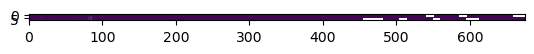

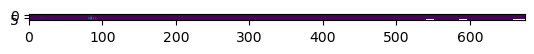

[0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1]


In [229]:
#First we need to organize into two arrays divided up by patient-
#These are used only for the statistical tests but could be plugged into the classification algorithms as well->
#Will likely want to automate but for now the patient id's are manually added to the list below->
#Normal vs Cancer Paired sets-
paired_pats=[251,258,261,268,270,271,393,410]


#Now going to do a super similar thing to what we did for the whole data set dividing the data into two arrays-

Healthy_data_paired=[]
Cancerous_data_paired=[]

#Dependent on the Normal sample coming befor the Tumor sample in the excel doc, a small price to pay for slightly less coding->
for i in range(len(paired_pats)):
    patient=paired_pats[i]
    #print(patient)
    #Find index of that patient data in order patient list-
    pat_indexlist=[j for j,x in enumerate(ordered_patID) if x==patient]
    print(pat_indexlist)
    #Healthy data will be first index in list-
    healthy_index=pat_indexlist[0]
    Healthy_data_paired.append(Array_in[healthy_index+1,:])
    #Cancerous data will be the last index in list (Barrets data not used here for not)-
    canc_index=pat_indexlist[-1]
    Cancerous_data_paired.append(Array_in[canc_index+1,:])
    
Healtharray_paired=np.array(Healthy_data_paired)
Cancarray_paired=np.array(Cancerous_data_paired)

#Check to make sure the two tissue types are properly divided->
print(Healtharray_paired[:,0])
print(Cancarray_paired[:,0])

healthmeans=np.nanmean(Healtharray_paired, axis=0)
healthformatfix=np.array(Healtharray_paired, dtype=np.float64)
healthstdevs=np.nanstd(healthformatfix, axis=0)
cancmeans=np.nanmean(Cancarray_paired, axis=0)
cancformatfix=np.array(Cancarray_paired, dtype=np.float64)
cancstdevs=np.nanstd(cancformatfix, axis=0)

#Handling Nan values by replacing with means->
# for i in range(Array_in.shape[1]-1):
#     hline=Healtharray_paired[:,i+1]
#     Healtharray_paired[:,i+1]=np.where(np.isnan(hline.astype('float64')),healthmeans[i+1],hline)
    
#     cline=Cancarray_paired[:,i+1]
#     Cancarray_paired[:,i+1]=np.where(np.isnan(cline.astype('float64')),cancmeans[i+1],cline)

plt.imshow(np.array(Healtharray_paired,dtype=float))
plt.show()

plt.imshow(np.array(Cancarray_paired,dtype=float))
plt.show()

print(Healtharray_paired[:,0],Cancarray_paired[:,0])

In [230]:
#Run Specified Stat Sig Test-
def SpecStatTest(testname, paired="y"):
    sig_feats=[]
    pvals=[]
    allpvalues={}
    
    for i in range(Healtharray_paired.shape[1]):
        if paired=="y":
            pval=testname(np.array(Healtharray_paired[:,i],dtype=float),np.array(Cancarray_paired[:,i],dtype=float), nan_policy='omit')[1]
        else:
            pval=testname(np.array(Partial_Healthy_Array[:,i],dtype=float),np.array(Partial_Canc_Array[:,i],dtype=float), nan_policy='omit')[1]
        #Add pvals to a list-
        pvals.append(pval)
    
    #print(len(pvals))
#Correct for multiple comparisons-
    #by imaging mode-
    FWER = 0.1
    updatedpvals=[0]
    for i in range(4):
        mstart=masterfileindicieslist[i][0]
        mend=masterfileindicieslist[i][1]
        #Can change method to bh to use benjamani hoochberg or by for benjamani yochateli->
        #modepvals=stats.false_discovery_control(pvals[mstart:mend], method='by')
        #bonferronicorrection instead->
        pval_adj = multitest.multipletests(np.array(pvals[mstart:mend]),method='fdr_bh',alpha=FWER)
        print(pval_adj[1][pval_adj[0]])
        modepvals=pval_adj[1]
        updatedpvals.extend(modepvals)
    

    #all the features at once-
#     updatedpvals=stats.false_discovery_control(pvals[1:], method='by')    
#Bonferoni correction
#    updatedpvals=pvals[1:]*(len(pvals)-1)

#Skip multiple comaprisons correction-
#    updatedpvals=pvals

#Add all the pvalues below threshold to a list of significant features->
    for i in range(Healtharray_paired.shape[1]):
        allpvalues[Array_in[0,i]]=updatedpvals[i]
        if updatedpvals[i]<FWER:
            sig_feats.append([i,Array_in[0,i],updatedpvals[i]])
    
    print(sig_feats)

    #If a p-value is less than 0.05, it is flagged with one star (*). If a p-value is less than 0.01, 
    #it is flagged with 2 stars (**). If a p-value is less than 0.001, it is flagged with three stars (***)
    #Just for plotting purposes->

    for i in range(len(sig_feats)):
        valp=sig_feats[i][2]
        if valp<0.05:
            sig_feats[i][2]=str("**")
        elif valp<0.1:
            sig_feats[i][2]=str("*")
    
    return(sig_feats, allpvalues)

#Plot bar chart with all the significant features by imaging type->
def SSFbarchart(ss_indicies, sigfeatlist, Title=""):
    start=ss_indicies[0]
    end=ss_indicies[1]
    features=[]
    health_means=[]
    canc_means=[]
    pval=[]
    for i in range(end-start):
        features.append(sigfeatlist[i+start][1])
        feat_index=sigfeatlist[i+start][0]
        pval.append(sigfeatlist[i+start][2])
        health_means.append(healthmeans[feat_index])
        canc_means.append(cancmeans[feat_index])
    
    #features to indexes in originalfile in-
    featindex=Indicies_From_Names(features, input_array=masterfile_in)
    propernames=Sort_From_Index(featindex, input_array=namefile)[1]
      
    feat_means = {
        'health_means': health_means,
        'canc_means': canc_means,
    }

    x = np.arange(len(features))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots()

    for attribute, measurement in feat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, np.log(np.abs(measurement)+1), width, label=attribute)
        if multiplier==0:
            ax.bar_label(rects, pval, padding=3, label_type='edge', rotation=0)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean Values')
    ax.set_title(Title+' significantly different features')
    ax.set_xticks(x + width/2, propernames, rotation=90,fontsize=10)
    #ax.legend(loc='upper left', ncols=3)
    #ax.set_ylim(0, 250)

    plt.show()
    return()

#Finds the significant features and plots them, allows you to adjust for test type->
def SSFeatureOrg(testname, paired="y"):

    sig_feats, allpvalues= SpecStatTest(testname, paired)

    Sig_featarray=np.array(sig_feats)
    
    #This gives the indicies in the sig_feats list which correspond to the different imaging types:
    #ssAF_indicies, ssHS_indicies, ssOCT_indicies, ssPLI_indicies = get_indicies(np.array(sig_feats)[:,1])
    Modes=["AF","HS","OCT","PLI"]
    
    print(np.array(sig_feats)[:,1])
    
    SSindecies= list(get_indicies(np.array(sig_feats)[:,1]))
    
    print(SSindecies)
    
    
    if SSindecies[3][1]-SSindecies[3][0]==0:
        SSindecies[3]=[]

    indicieslist=[]
    for i in range(len(SSindecies)):
        if len(SSindecies[i])>0:
            SSFbarchart(SSindecies[i], sig_feats, Modes[i])
            indicieslist.append(Sig_featarray[SSindecies[i][0]:SSindecies[i][1],0].astype(int))
        else:
            indicieslist.append([])
      
    AFSSI, HSSSI, OCTSSI, PLISSI= indicieslist
    AllSSI=np.concatenate((AFSSI, HSSSI, OCTSSI, PLISSI))

    return(allpvalues, AFSSI, HSSSI, OCTSSI, PLISSI, AllSSI)

In [231]:
#initial SS test for later used Pvals-

#Run Specified Stat Sig Test-
def SpecStatTest(testname, paired="y"):
    sig_feats=[]
    pvals=[]
    allpvalues={}
    
    for i in range(Healtharray_paired.shape[1]):
        if paired=="y":
            pval=testname(np.array(Healtharray_paired[:,i],dtype=float),np.array(Cancarray_paired[:,i],dtype=float), nan_policy='omit')[1]
        else:
            pval=testname(np.array(Partial_Healthy_Array[:,i],dtype=float),np.array(Partial_Canc_Array[:,i],dtype=float), nan_policy='omit')[1]
        #Add pvals to a list-
        pvals.append(pval)
    
    #print(len(pvals))
#Correct for multiple comparisons-
    #by imaging mode-
    FWER = 0.1
    updatedpvals=[0]
    for i in range(4):
        mstart=masterfileindicieslist[i][0]
        mend=masterfileindicieslist[i][1]
        #Can change method to bh to use benjamani hoochberg or by for benjamani yochateli->
        #modepvals=stats.false_discovery_control(pvals[mstart:mend], method='by')
        #bonferronicorrection instead->
        print("hiii",pvals[mstart:mend])
        pval_adj = multitest.multipletests(np.array(pvals[mstart:mend]),method='fdr_bh',alpha=FWER)
        print(pval_adj[1][pval_adj[0]])
        modepvals=pval_adj[1]
        updatedpvals.extend(modepvals)
    

    #all the features at once-
#     updatedpvals=stats.false_discovery_control(pvals[1:], method='by')    
#Bonferoni correction
#    updatedpvals=pvals[1:]*(len(pvals)-1)

#Skip multiple comaprisons correction-
#    updatedpvals=pvals

#Add all the pvalues below threshold to a list of significant features->
    for i in range(Healtharray_paired.shape[1]):
        allpvalues[Array_in[0,i]]=updatedpvals[i]
        if updatedpvals[i]<FWER:
            sig_feats.append([i,Array_in[0,i],updatedpvals[i]])
    
    print(sig_feats)

    #If a p-value is less than 0.05, it is flagged with one star (*). If a p-value is less than 0.01, 
    #it is flagged with 2 stars (**). If a p-value is less than 0.001, it is flagged with three stars (***)
    #Just for plotting purposes->

    for i in range(len(sig_feats)):
        valp=sig_feats[i][2]
        if valp<0.05:
            sig_feats[i][2]=str("**")
        elif valp<0.1:
            sig_feats[i][2]=str("*")
    
    return(sig_feats, allpvalues)

#Finds the significant features and plots them, allows you to adjust for test type->
def SSFeatureForPvals(testname, paired="y"):

    sig_feats, allpvalues= SpecStatTest(testname, paired)

    Sig_featarray=np.array(sig_feats)
    
    print(np.array(sig_feats)[:,1])

    return(allpvalues)

In [232]:
#Paired tests->
#print("Paired Sig Feats-")
#allwpvalues = SSFeatureForPvals(wilcoxon)

#unpaired tests->
print("Unpaired Sig Feats-")
allmwpvalues = SSFeatureForPvals(mannwhitneyu,"n")



Unpaired Sig Feats-
hiii [0.6080768794659228, 0.8777310415017161, 0.5049850750938458, 0.8374719604535413, 0.4727889073230682, 0.7976340690559742, 0.6080768794659228, 0.5049850750938458, 0.5383007490187228, 0.18242243945173575, 0.6444123337698114, 0.08123065302087974, 0.6816178642730836, 0.13696741226229456, 0.0577704316108834, 0.6816178642730836, 0.3833202927297332, 0.28151463251002273, 0.30506082202155305, 0.2184091866192417, 0.259233298673899, 0.23820423879927, 0.19982465733238353, 0.3833202927297332, 0.23820423879927, 0.3298783320498747, 0.4119238236601619, 0.57268433313998, 0.7196142711598057, 0.7196142711598057, 0.1239358056727424, 0.23820423879927, 0.15103152823115532, 0.23820423879927, 0.15103152823115532, 0.13696741226229456, 0.2184091866192417, 0.027445099375459536, 0.3833202927297332, 0.07267412867689323, 0.8374719604535413, 0.6816178642730836, 0.1239358056727424, 0.15103152823115532, 0.13696741226229456, 0.08123065302087974, 0.1239358056727424, 0.07267412867689323, 0.1661701

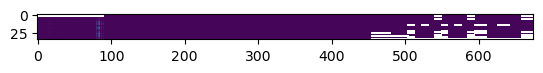

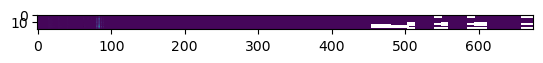

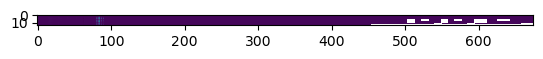

(20, 675) (14, 675) (0,)


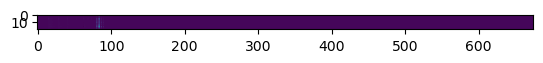

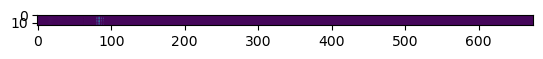

(20, 675) (14, 675) (0,)
(14, 675) (14, 675)
(29, 675)


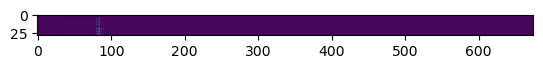

In [233]:
#Reorgaizing data without nans-
plt.imshow(np.array(Array_in[1:,:],dtype=float))
plt.show()

Healthy_data=[]
Cancerous_data=[]

#Assign 0 to healthy samples, 1 to cancerous and 2 to Barretts->
for i in range(Array_in.shape[0]-1):
    if Array_in[i+1,0]==0:
        Healthy_data.append(Array_in[i+1,:])
    elif Array_in[i+1,0]==2:
        Barretts_data.append(Array_in[i+1,:])
    else:
        Cancerous_data.append(Array_in[i+1,:])

Healtharray=np.array(Healthy_data)
Cancarray=np.array(Cancerous_data)

plt.imshow(np.array(Healtharray,dtype=float))
plt.show()
plt.imshow(np.array(Cancarray,dtype=float))
plt.show()


print(Healtharray.shape, Cancarray.shape, Barrettsarray.shape)

healthmeans=np.nanmean(Healtharray, axis=0)
cancmeans=np.nanmean(Cancarray, axis=0)

#*** Handling for missing values- filling in missing vals with means *** ->
for i in range(Array_in.shape[1]-1):
    hline=Healtharray[:,i+1]
    Healtharray[:,i+1]=np.where(np.isnan(hline.astype('float64')),healthmeans[i+1],hline)
    
    cline=Cancarray[:,i+1]
    Cancarray[:,i+1]=np.where(np.isnan(cline.astype('float64')),cancmeans[i+1],cline)
    

plt.imshow(np.array(Healtharray,dtype=float))
plt.show()
plt.imshow(np.array(Cancarray,dtype=float))
plt.show()

print(Healtharray.shape,Cancarray.shape,Barrettsarray.shape)

#Take feature names seperately->
labels=Array_in[0,:].reshape(1, len(Array_in[0,:]))

#Option to only take some of the healthy data to even things out, by taking only part of the arrays below-
#There's likely a more "fair" way to do this but for now I think the later data is more self consistent so I'm going to favor that-
Partial_Healthy_Array=Healtharray[:partialindex,:]
Partial_Canc_Array=Cancarray[:partialindex,:]

print(Partial_Healthy_Array.shape,Partial_Canc_Array.shape)

masterfile=np.concatenate((labels,Partial_Healthy_Array,Partial_Canc_Array))

print(masterfile.shape)

f=plt.imshow(np.array(masterfile[1:,:],dtype=float))
plt.show()

In [234]:
#Let's get classifying! First organizing the data a bit-
#Y is binary classification type-
y=masterfile[1:,0].astype('float64')

#All Features from each imaging type-
All=masterfile[:,1:]
AF=masterfile[:,AF_indicies[0]:AF_indicies[1]]
HS=masterfile[:,HS_indicies[0]:HS_indicies[1]]
OCT=masterfile[:,OCT_indicies[0]:OCT_indicies[1]]
PLI=masterfile[:,PLI_indicies[0]:PLI_indicies[1]]


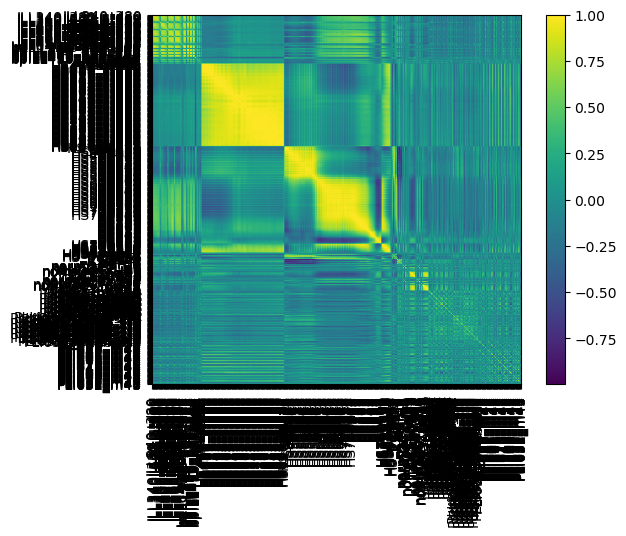

0
(674, 674)
216 (2, 675)
['ILL460_500' 'ILL340_561_stdev' 'ILL460_594_stdev' 'ILL340_594_stdev'
 'ILL460_532' 'ILL490_561' 'ILL460_647' 'ILL340_647_stdev' 'ILL400_380'
 'ILL400_380_stdev' 'ILL400_500_stdev' 'ILL460_561_stdev'
 'ILL400_532_stdev' 'ILL400_594_stdev' 'ILL460_561' 'ILL490_532'
 'ILL640_380' 'ILL640_380_stdev' 'ILL490_594' 'ILL647_647_stdev'
 'bpILL340_380_430' 'bpILL400_380_430' 'ILL400_430_stdev'
 'bpILL460_500_532' 'ILL340S' 'ILL340G' 'ILL400S' 'ILL400G' 'ILL400_532'
 'ILL460S' 'ILL460G' 'ILL490S' 'HS554_stdev' 'HS591_stdev' 'HS562_stdev'
 'HS583_stdev' 'HS594_stdev' 'HS571_stdev' 'HS559_stdev' 'HS606_stdev'
 'HS780ave' 'HSS2' 'HS533' 'HS539' 'HS542' 'HS583' 'HS626' 'HS540ave'
 'HS629' 'HS634' 'HS637' 'HS640' 'HS649' 'HS655' 'HS680ave' 'HS759'
 'HS761' 'HS764' 'HS767' 'HS770' 'HS779' 'HS790' 'HS822' 'HS825' 'HS831'
 'HS834' 'HS837' 'HS839' 'HS842' 'HS848' 'HS874' 'HS880' 'HS773' 'HS793'
 'HS770ave' 'HS800ave' 'HS820ave' 'HS_param1' 'HS_param2' 'HS727' 'HSG'
 'HSF_3' 'HS

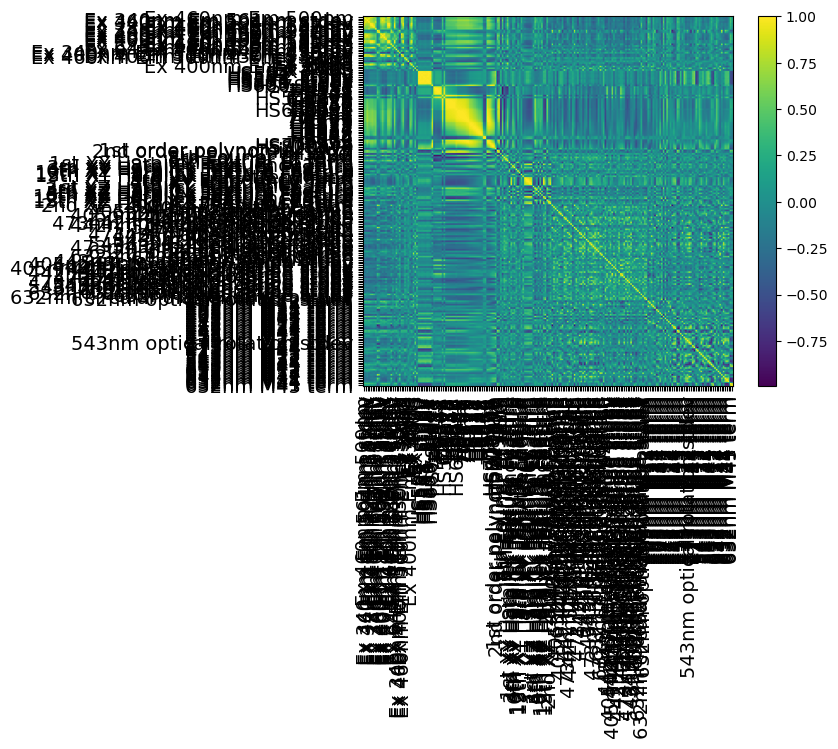

216
(216, 216)
160 (2, 675)
['ILL460_500' 'ILL460_594_stdev' 'ILL490_561' 'ILL340_647_stdev'
 'ILL400_380' 'ILL400_380_stdev' 'ILL340_561_stdev' 'ILL460_561_stdev'
 'ILL400_594_stdev' 'ILL640_380' 'ILL640_380_stdev' 'ILL647_647_stdev'
 'bpILL340_380_430' 'bpILL400_380_430' 'ILL400_500_stdev' 'ILL340S'
 'ILL340G' 'ILL400S' 'ILL400G' 'ILL460S' 'ILL460G' 'ILL490S' 'HS594_stdev'
 'HS793' 'HS542' 'HS629' 'HS637' 'HS680ave' 'HS764' 'HS767' 'HS779'
 'HS790' 'HS822' 'HS825' 'HS831' 'HS837' 'HS880' 'HS770ave' 'HS_param1'
 'HS_param2' 'HSG' 'HSF_3' 'HSF_4' 'HSF_5' 'HSF_6' 'normOCT_H1'
 'OCT_freq7' 'normOCT_H3' 'normOCT_H4' 'normOCTY_H6' 'normOCT_H10'
 'normOCT_H12' 'normOCT_H13' 'OCT_atten' 'OCT_freq2' 'normOCTY_H1'
 'normOCTY_H3' 'normOCTY_H4' 'normOCTY_H5' 'normOCTY_H10' 'normOCTY_H12'
 'normOCTY_H13' 'OCTY_freq1' 'PLI473_m42' 'PLI405_diatten' 'PLI442_depol'
 'PLI405_diang' 'PLI632_linret' 'PLI405_cdia' 'PLI543_optrot'
 'PLI473_polar' 'PLI442_diatten' 'PLI442_diang' 'PLI473_linret_std'
 'PLI44

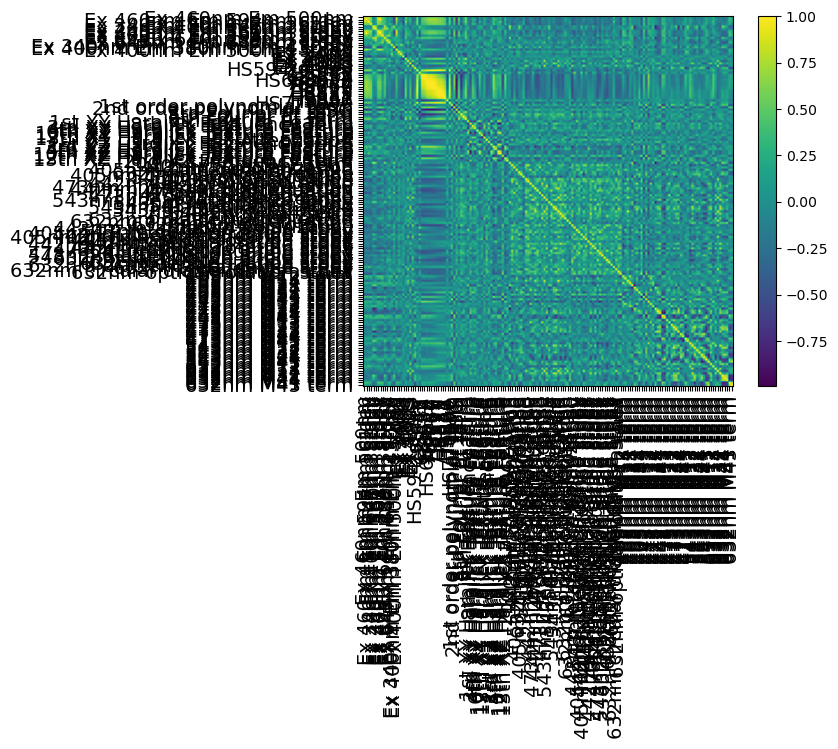

160
(160, 160)
145 (2, 675)
['ILL460_500' 'ILL460_594_stdev' 'ILL340_647_stdev' 'ILL400_380'
 'ILL400_380_stdev' 'ILL400_594_stdev' 'ILL640_380' 'ILL640_380_stdev'
 'ILL647_647_stdev' 'bpILL340_380_430' 'bpILL400_380_430'
 'ILL340_561_stdev' 'ILL340S' 'ILL340G' 'ILL400S' 'ILL400G' 'ILL460S'
 'ILL460G' 'ILL490S' 'HS594_stdev' 'HS793' 'HS542' 'HS629' 'HS822' 'HS880'
 'HS_param1' 'HS_param2' 'HSG' 'HSF_3' 'HSF_4' 'HSF_5' 'HSF_6'
 'normOCT_H1' 'OCT_freq7' 'normOCT_H3' 'normOCT_H4' 'normOCTY_H6'
 'normOCT_H10' 'normOCT_H12' 'normOCT_H13' 'OCT_atten' 'OCT_freq2'
 'normOCTY_H1' 'normOCTY_H3' 'normOCTY_H4' 'normOCTY_H5' 'normOCTY_H10'
 'normOCTY_H12' 'normOCTY_H13' 'OCTY_freq1' 'PLI473_m42' 'PLI405_diatten'
 'PLI442_depol' 'PLI405_diang' 'PLI632_linret' 'PLI405_cdia'
 'PLI543_optrot' 'PLI473_polar' 'PLI442_diatten' 'PLI442_diang'
 'PLI473_linret_std' 'PLI442_cdia' 'PLI473_diatten' 'PLI473_depol'
 'PLI473_diang' 'PLI632_ret' 'PLI543_retang' 'PLI543_diatten'
 'PLI543_diang' 'PLI543_linret' 'PLI5

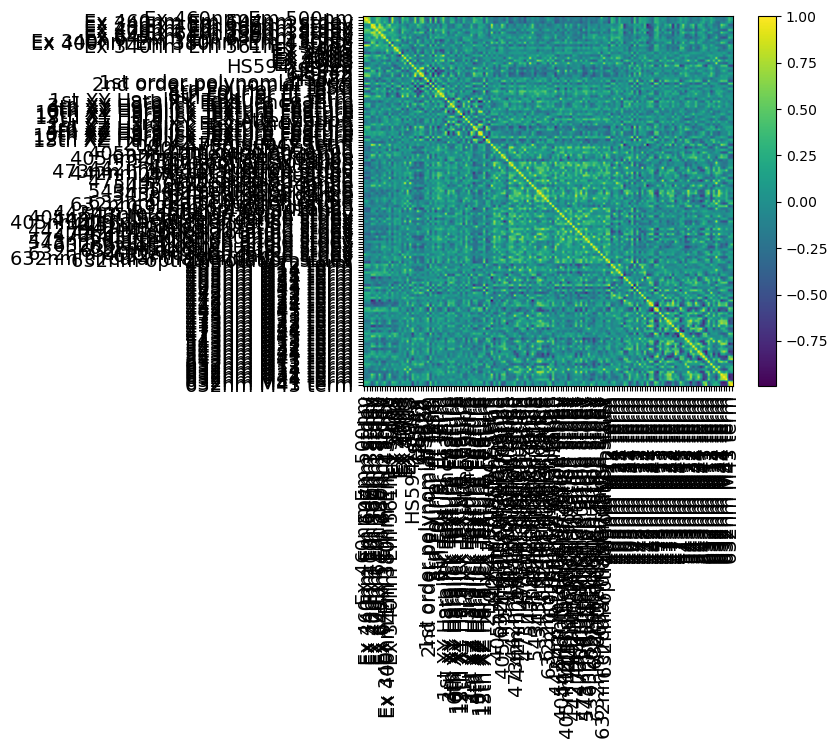

145
(145, 145)
143 (2, 675)
['ILL460_500' 'ILL460_594_stdev' 'ILL340_647_stdev' 'ILL400_380'
 'ILL400_380_stdev' 'ILL400_594_stdev' 'ILL640_380' 'ILL640_380_stdev'
 'ILL647_647_stdev' 'bpILL340_380_430' 'bpILL400_380_430' 'ILL340S'
 'ILL340G' 'ILL400S' 'ILL400G' 'ILL460S' 'ILL460G' 'ILL490S' 'HS594_stdev'
 'HS793' 'HS542' 'HS629' 'HS880' 'HS_param1' 'HS_param2' 'HSG' 'HSF_3'
 'HSF_4' 'HSF_5' 'HSF_6' 'normOCT_H1' 'OCT_freq7' 'normOCT_H3'
 'normOCT_H4' 'normOCTY_H6' 'normOCT_H10' 'normOCT_H12' 'normOCT_H13'
 'OCT_atten' 'OCT_freq2' 'normOCTY_H1' 'normOCTY_H3' 'normOCTY_H4'
 'normOCTY_H5' 'normOCTY_H10' 'normOCTY_H12' 'normOCTY_H13' 'OCTY_freq1'
 'PLI473_m42' 'PLI405_diatten' 'PLI442_depol' 'PLI405_diang'
 'PLI632_linret' 'PLI405_cdia' 'PLI543_optrot' 'PLI473_polar'
 'PLI442_diatten' 'PLI442_diang' 'PLI473_linret_std' 'PLI442_cdia'
 'PLI473_diatten' 'PLI473_depol' 'PLI473_diang' 'PLI632_ret'
 'PLI543_retang' 'PLI543_diatten' 'PLI543_diang' 'PLI543_linret'
 'PLI543_polar' 'PLI632_diatten' 

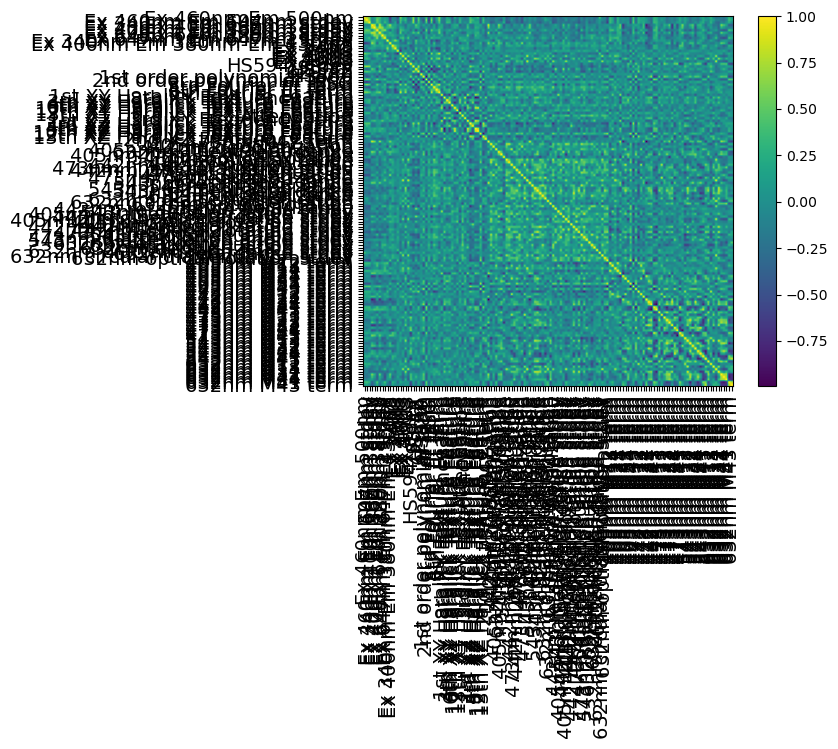

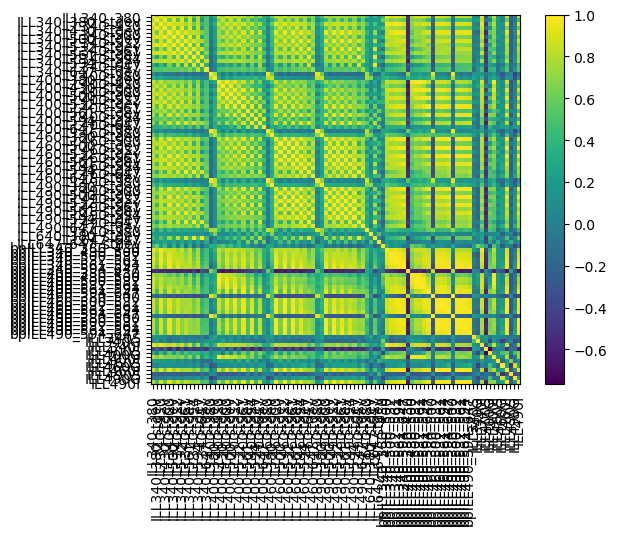

0
(90, 90)
32 (2, 675)
['ILL460_500' 'ILL340_561_stdev' 'ILL460_594_stdev' 'ILL340_594_stdev'
 'ILL460_532' 'ILL490_561' 'ILL460_647' 'ILL340_647_stdev' 'ILL400_380'
 'ILL400_380_stdev' 'ILL400_500_stdev' 'ILL460_561_stdev'
 'ILL400_532_stdev' 'ILL400_594_stdev' 'ILL460_561' 'ILL490_532'
 'ILL640_380' 'ILL640_380_stdev' 'ILL490_594' 'ILL647_647_stdev'
 'bpILL340_380_430' 'bpILL400_380_430' 'ILL400_430_stdev'
 'bpILL460_500_532' 'ILL340S' 'ILL340G' 'ILL400S' 'ILL400G' 'ILL400_532'
 'ILL460S' 'ILL460G' 'ILL490S']


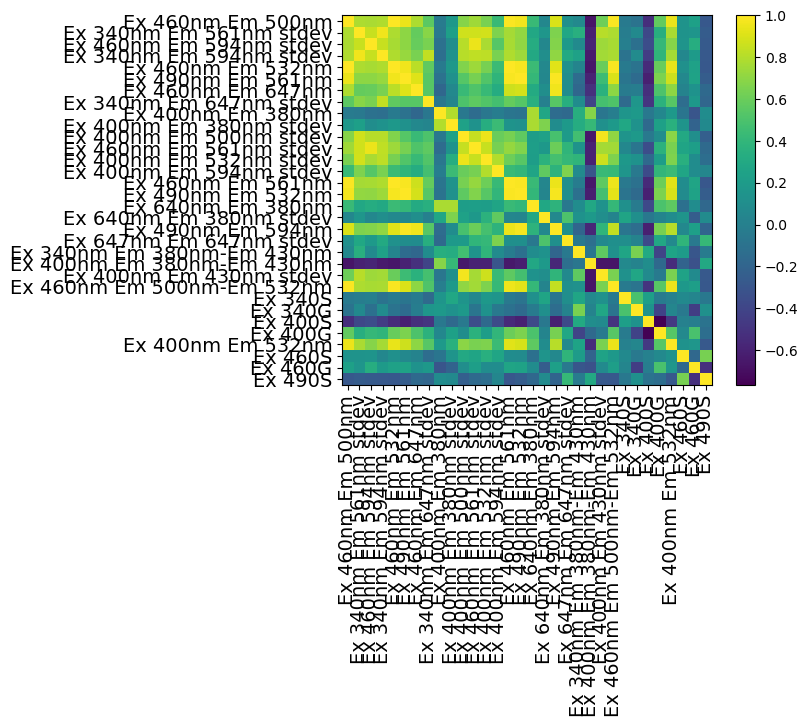

32
(32, 32)
22 (2, 675)
['ILL460_500' 'ILL460_594_stdev' 'ILL490_561' 'ILL340_647_stdev'
 'ILL400_380' 'ILL400_380_stdev' 'ILL340_561_stdev' 'ILL460_561_stdev'
 'ILL400_594_stdev' 'ILL640_380' 'ILL640_380_stdev' 'ILL647_647_stdev'
 'bpILL340_380_430' 'bpILL400_380_430' 'ILL400_500_stdev' 'ILL340S'
 'ILL340G' 'ILL400S' 'ILL400G' 'ILL460S' 'ILL460G' 'ILL490S']


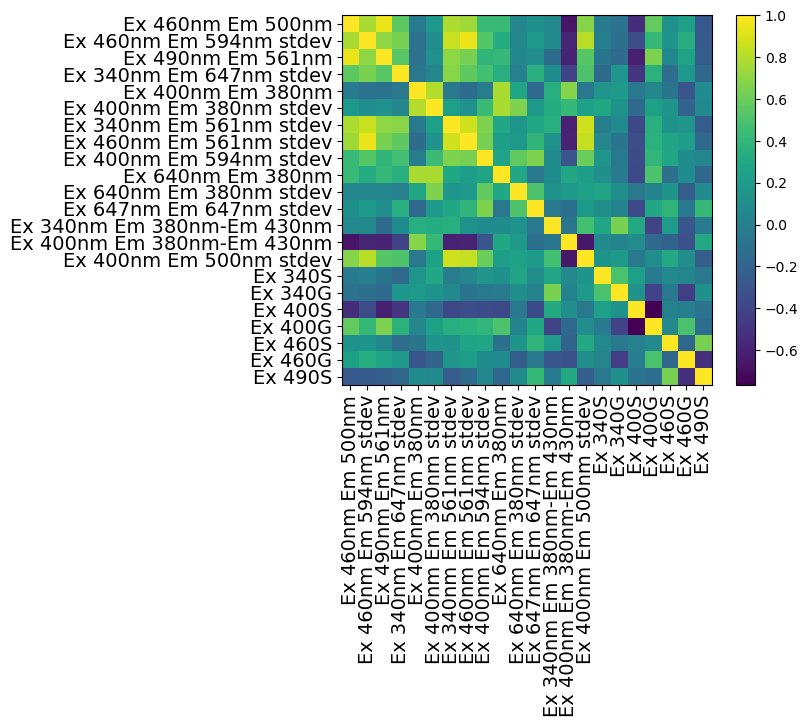

22
(22, 22)
19 (2, 675)
['ILL460_500' 'ILL460_594_stdev' 'ILL340_647_stdev' 'ILL400_380'
 'ILL400_380_stdev' 'ILL400_594_stdev' 'ILL640_380' 'ILL640_380_stdev'
 'ILL647_647_stdev' 'bpILL340_380_430' 'bpILL400_380_430'
 'ILL340_561_stdev' 'ILL340S' 'ILL340G' 'ILL400S' 'ILL400G' 'ILL460S'
 'ILL460G' 'ILL490S']


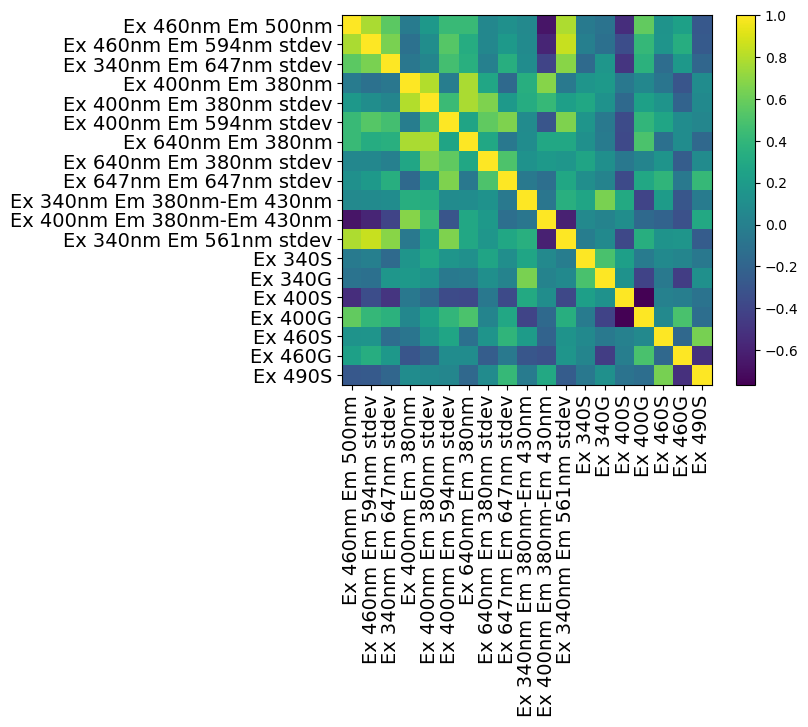

19
(19, 19)
18 (2, 675)
['ILL460_500' 'ILL460_594_stdev' 'ILL340_647_stdev' 'ILL400_380'
 'ILL400_380_stdev' 'ILL400_594_stdev' 'ILL640_380' 'ILL640_380_stdev'
 'ILL647_647_stdev' 'bpILL340_380_430' 'bpILL400_380_430' 'ILL340S'
 'ILL340G' 'ILL400S' 'ILL400G' 'ILL460S' 'ILL460G' 'ILL490S']


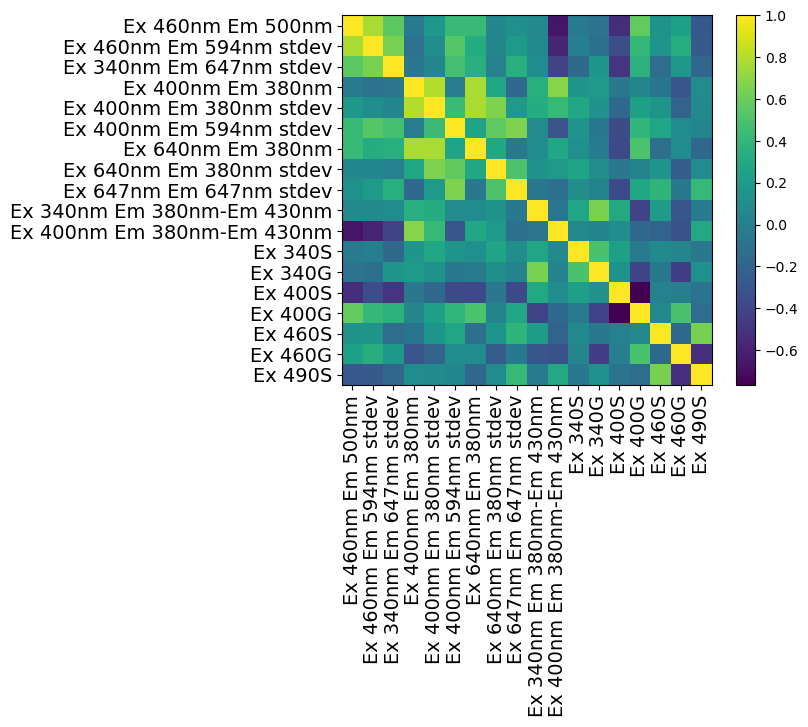

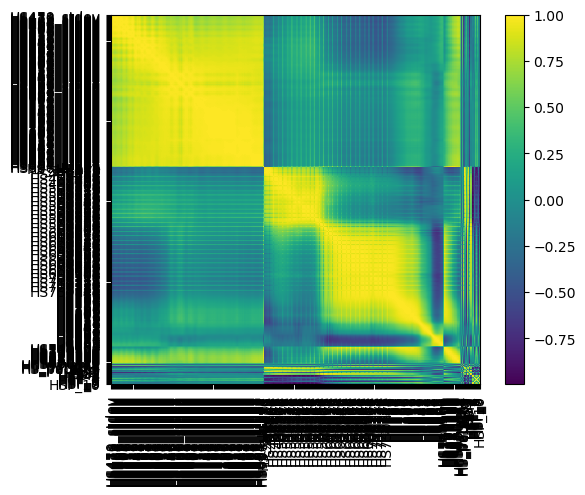

0
(365, 365)
53 (2, 675)
['HS554_stdev' 'HS591_stdev' 'HS562_stdev' 'HS583_stdev' 'HS594_stdev'
 'HS571_stdev' 'HS559_stdev' 'HS606_stdev' 'HS780ave' 'HSS2' 'HS533'
 'HS539' 'HS542' 'HS583' 'HS626' 'HS540ave' 'HS629' 'HS634' 'HS637'
 'HS640' 'HS649' 'HS655' 'HS680ave' 'HS759' 'HS761' 'HS764' 'HS767'
 'HS770' 'HS779' 'HS790' 'HS822' 'HS825' 'HS831' 'HS834' 'HS837' 'HS839'
 'HS842' 'HS848' 'HS874' 'HS880' 'HS773' 'HS793' 'HS770ave' 'HS800ave'
 'HS820ave' 'HS_param1' 'HS_param2' 'HS727' 'HSG' 'HSF_3' 'HSF_4' 'HSF_5'
 'HSF_6']


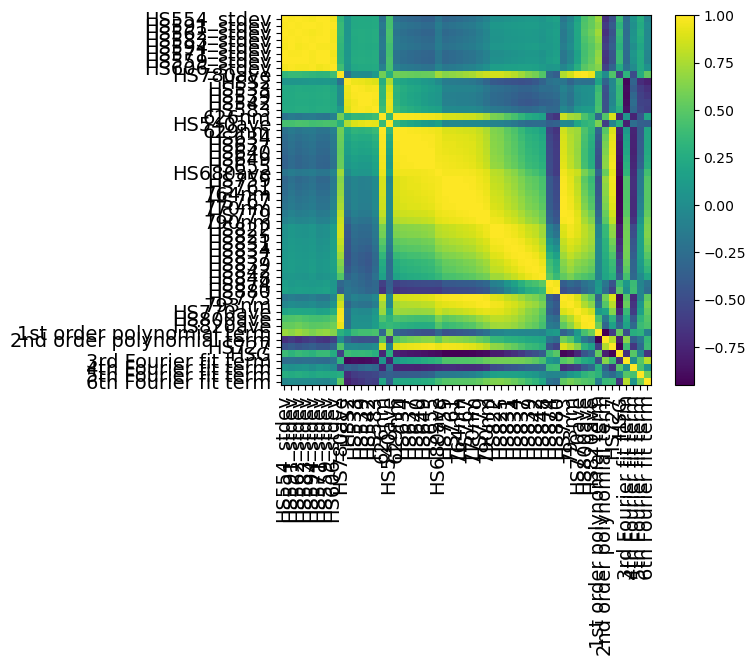

53
(53, 53)
23 (2, 675)
['HS594_stdev' 'HS793' 'HS542' 'HS629' 'HS637' 'HS680ave' 'HS764' 'HS767'
 'HS779' 'HS790' 'HS822' 'HS825' 'HS831' 'HS837' 'HS880' 'HS770ave'
 'HS_param1' 'HS_param2' 'HSG' 'HSF_3' 'HSF_4' 'HSF_5' 'HSF_6']


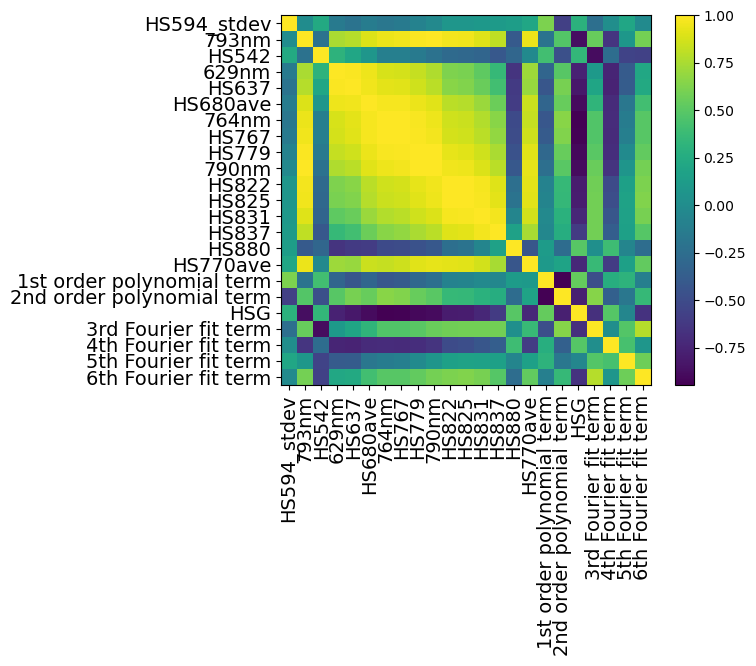

23
(23, 23)
13 (2, 675)
['HS594_stdev' 'HS793' 'HS542' 'HS629' 'HS822' 'HS880' 'HS_param1'
 'HS_param2' 'HSG' 'HSF_3' 'HSF_4' 'HSF_5' 'HSF_6']


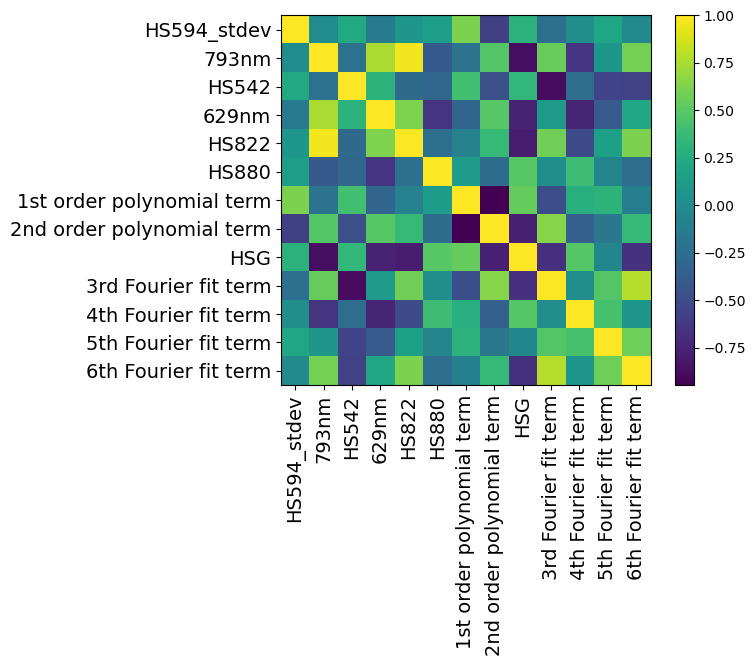

13
(13, 13)
12 (2, 675)
['HS594_stdev' 'HS793' 'HS542' 'HS629' 'HS880' 'HS_param1' 'HS_param2'
 'HSG' 'HSF_3' 'HSF_4' 'HSF_5' 'HSF_6']


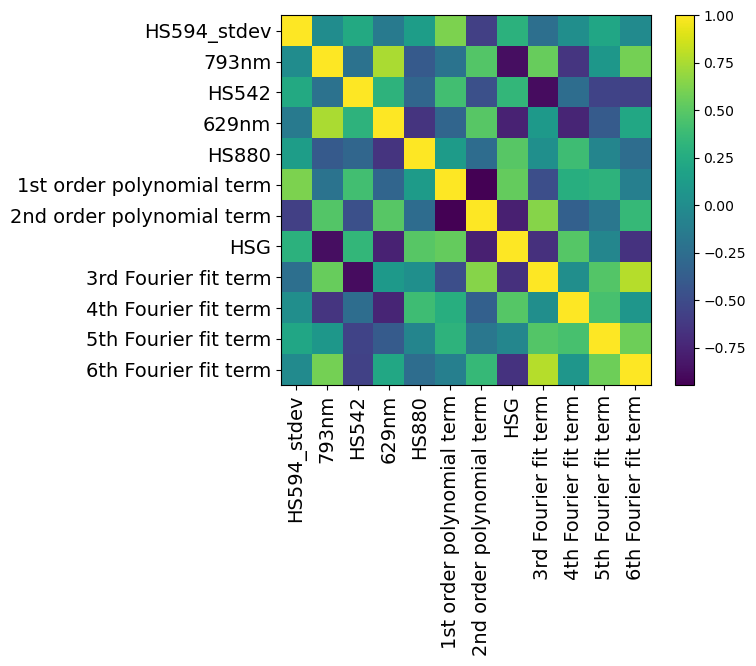

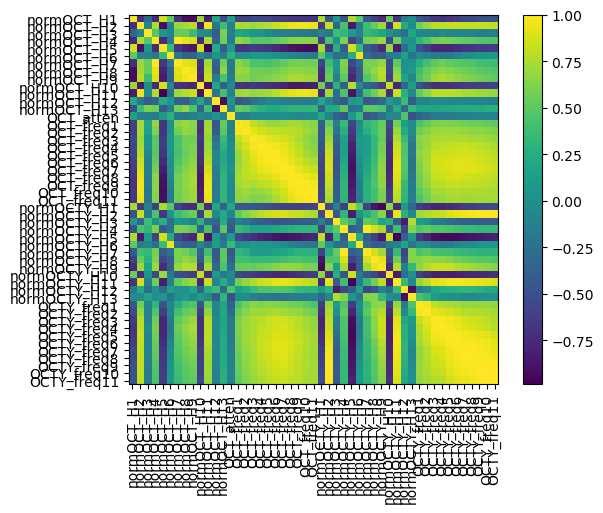

0
(49, 49)
25 (2, 675)
['normOCT_H1' 'OCT_freq7' 'normOCT_H3' 'normOCT_H4' 'normOCTY_H6'
 'normOCT_H10' 'normOCT_H12' 'normOCT_H13' 'OCT_atten' 'OCT_freq2'
 'OCT_freq3' 'OCT_freq4' 'OCT_freq6' 'OCT_freq8' 'normOCTY_H1'
 'normOCTY_H3' 'normOCTY_H4' 'normOCTY_H5' 'normOCTY_H8' 'normOCTY_H10'
 'OCT_freq5' 'normOCTY_H12' 'normOCTY_H13' 'OCTY_freq1' 'normOCTY_H2']


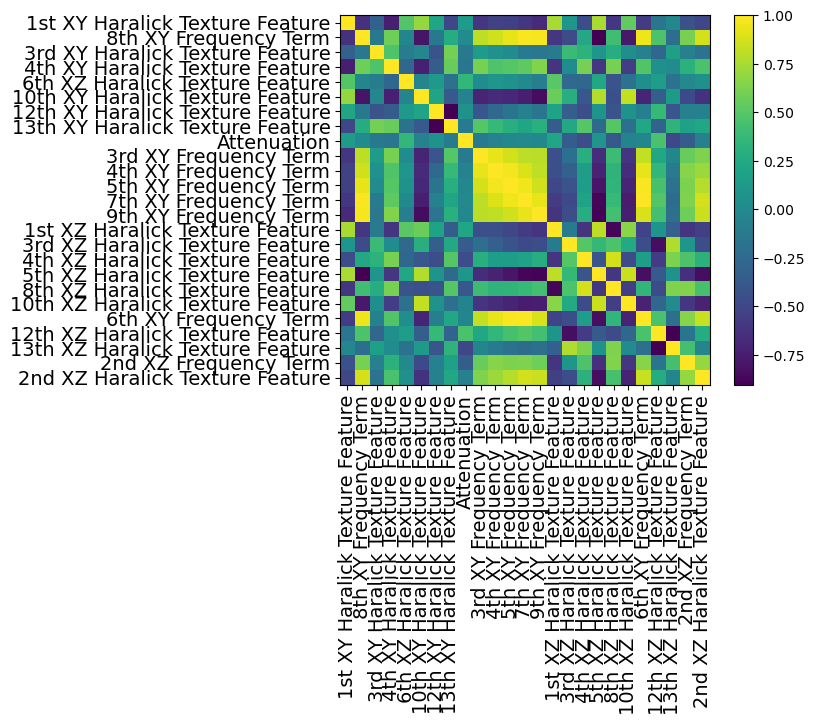

25
(25, 25)
18 (2, 675)
['normOCT_H1' 'OCT_freq7' 'normOCT_H3' 'normOCT_H4' 'normOCTY_H6'
 'normOCT_H10' 'normOCT_H12' 'normOCT_H13' 'OCT_atten' 'OCT_freq2'
 'normOCTY_H1' 'normOCTY_H3' 'normOCTY_H4' 'normOCTY_H5' 'normOCTY_H10'
 'normOCTY_H12' 'normOCTY_H13' 'OCTY_freq1']


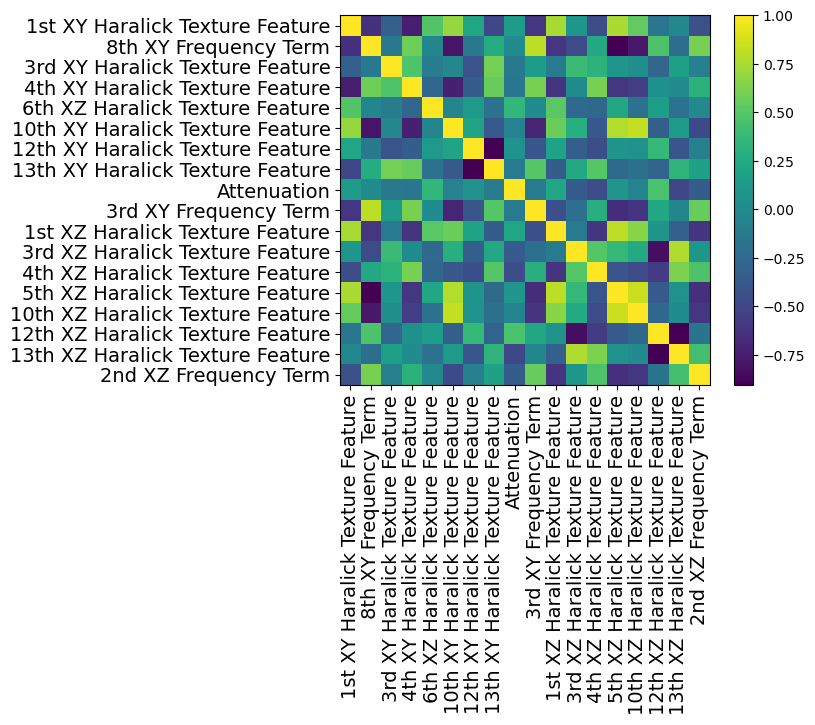

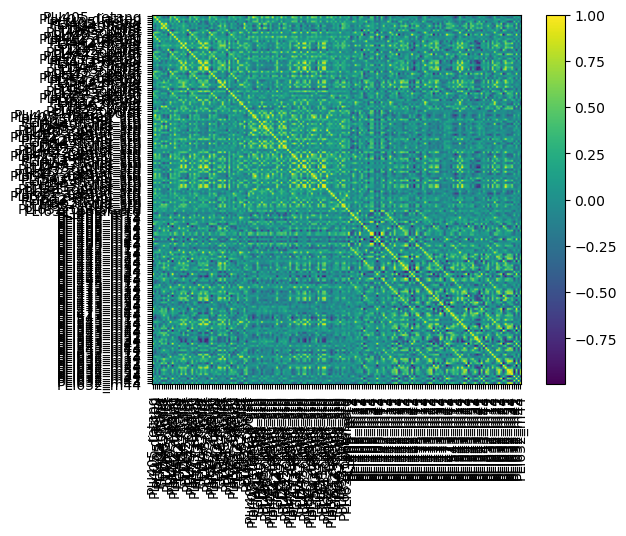

0
(170, 170)
106 (2, 675)
['PLI473_m42' 'PLI405_diatten' 'PLI442_depol' 'PLI405_diang'
 'PLI632_linret' 'PLI405_cdia' 'PLI442_optrot' 'PLI473_polar'
 'PLI442_diatten' 'PLI442_diang' 'PLI473_linret_std' 'PLI442_cdia'
 'PLI543_optrot' 'PLI442_m42' 'PLI473_diatten' 'PLI473_depol'
 'PLI473_diang' 'PLI442_linret' 'PLI442_m14' 'PLI543_m21' 'PLI543_retang'
 'PLI543_diatten' 'PLI543_diang' 'PLI543_linret' 'PLI473_cdia'
 'PLI543_polar' 'PLI632_diatten' 'PLI632_diang' 'PLI632_ret' 'PLI632_cdia'
 'PLI632_optrot' 'PLI632_polar' 'PLI442_retang_std' 'PLI543_depol_std'
 'PLI405_diang_std' 'PLI442_linret_std' 'PLI405_cdia_std'
 'PLI405_optrot_std' 'PLI442_depol_std' 'PLI442_diang_std'
 'PLI442_ret_std' 'PLI442_optrot_std' 'PLI473_retang_std'
 'PLI543_diatten_std' 'PLI473_diang_std' 'PLI473_depol_std'
 'PLI543_linret_std' 'PLI543_diang_std' 'PLI632_retang_std'
 'PLI632_diatten_std' 'PLI632_depol_std' 'PLI632_diang_std'
 'PLI632_ret_std' 'PLI632_cdia_std' 'PLI632_optrot_std' 'PLI405_m22'
 'PLI405_m12' '

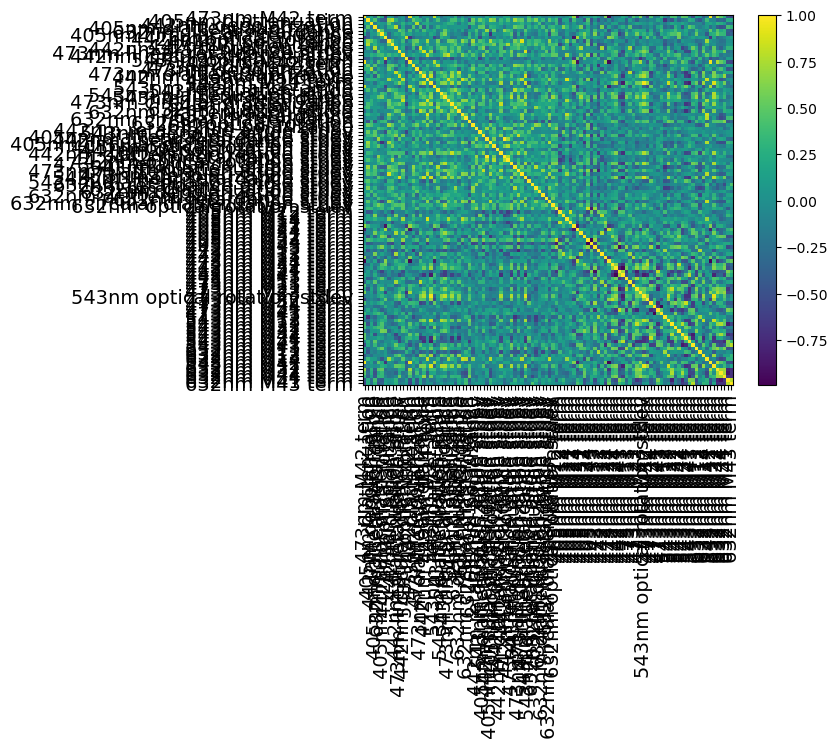

106
(106, 106)
97 (2, 675)
['PLI473_m42' 'PLI405_diatten' 'PLI442_depol' 'PLI405_diang'
 'PLI632_linret' 'PLI405_cdia' 'PLI543_optrot' 'PLI473_polar'
 'PLI442_diatten' 'PLI442_diang' 'PLI473_linret_std' 'PLI442_cdia'
 'PLI473_diatten' 'PLI473_depol' 'PLI473_diang' 'PLI632_ret'
 'PLI543_linret_std' 'PLI543_retang' 'PLI543_diatten' 'PLI543_diang'
 'PLI543_linret' 'PLI442_m14' 'PLI543_polar' 'PLI632_diatten'
 'PLI632_diang' 'PLI632_cdia' 'PLI632_optrot' 'PLI632_polar'
 'PLI442_retang_std' 'PLI543_depol_std' 'PLI405_diang_std'
 'PLI442_linret_std' 'PLI405_cdia_std' 'PLI405_optrot_std'
 'PLI442_depol_std' 'PLI442_diang_std' 'PLI442_optrot_std'
 'PLI473_retang_std' 'PLI543_diatten_std' 'PLI473_diang_std'
 'PLI543_diang_std' 'PLI632_retang_std' 'PLI632_diatten_std'
 'PLI632_depol_std' 'PLI632_diang_std' 'PLI632_ret_std' 'PLI632_cdia_std'
 'PLI632_optrot_std' 'PLI405_m22' 'PLI405_m12' 'PLI405_m13' 'PLI405_m14'
 'PLI405_m21' 'PLI405_m23' 'PLI405_m24' 'PLI405_m31' 'PLI405_m32'
 'PLI405_m34' 'PLI

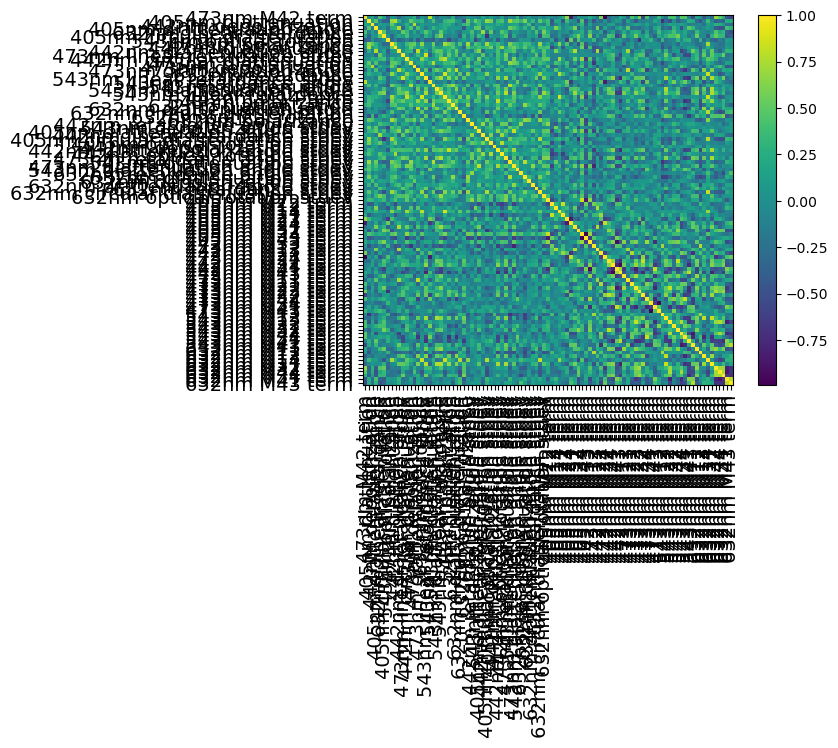

97
(97, 97)
95 (2, 675)
['PLI473_m42' 'PLI405_diatten' 'PLI442_depol' 'PLI405_diang'
 'PLI632_linret' 'PLI405_cdia' 'PLI543_optrot' 'PLI473_polar'
 'PLI442_diatten' 'PLI442_diang' 'PLI473_linret_std' 'PLI442_cdia'
 'PLI473_diatten' 'PLI473_depol' 'PLI473_diang' 'PLI632_ret'
 'PLI543_retang' 'PLI543_diatten' 'PLI543_diang' 'PLI543_linret'
 'PLI543_polar' 'PLI632_diatten' 'PLI632_diang' 'PLI632_cdia'
 'PLI632_optrot' 'PLI632_polar' 'PLI442_retang_std' 'PLI543_depol_std'
 'PLI405_diang_std' 'PLI442_linret_std' 'PLI405_cdia_std'
 'PLI405_optrot_std' 'PLI442_depol_std' 'PLI442_diang_std'
 'PLI442_optrot_std' 'PLI473_retang_std' 'PLI543_diatten_std'
 'PLI473_diang_std' 'PLI543_diang_std' 'PLI632_retang_std'
 'PLI632_diatten_std' 'PLI632_depol_std' 'PLI632_diang_std'
 'PLI632_ret_std' 'PLI632_cdia_std' 'PLI632_optrot_std' 'PLI405_m22'
 'PLI405_m12' 'PLI405_m13' 'PLI405_m14' 'PLI405_m21' 'PLI405_m23'
 'PLI405_m24' 'PLI405_m31' 'PLI405_m32' 'PLI405_m34' 'PLI405_m43'
 'PLI442_m33' 'PLI473_m12' '

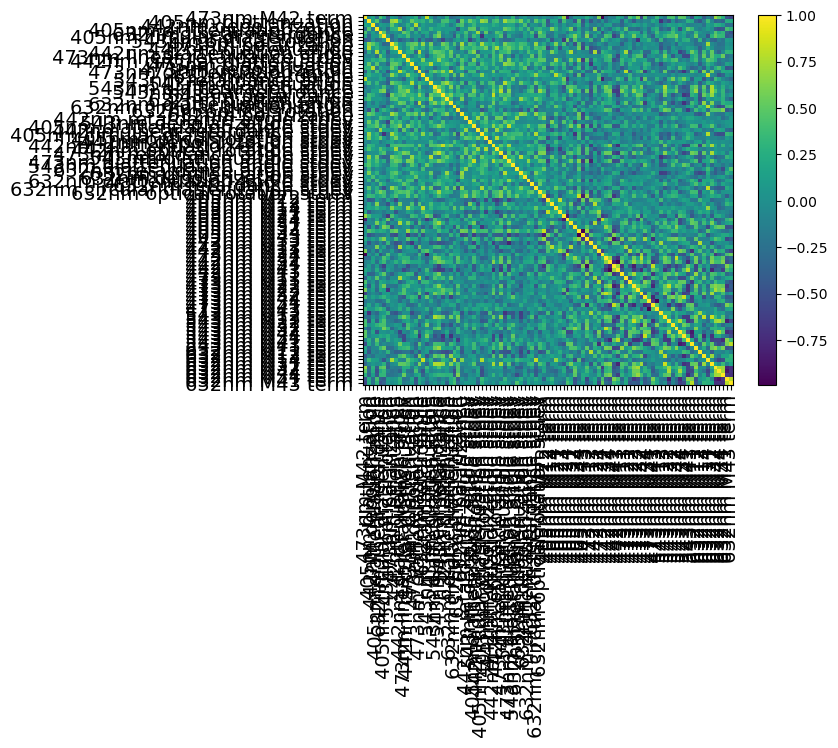

In [235]:
#Reduction by correlation between features
#Starting from arrays formatted to be plugged into classifiers, returning arrays in that same format with highly coorelated features eliminated-
def correduce(datain,incplots="y"):
    arrayin=datain
    names=arrayin[0,:]

    cor=np.corrcoef(arrayin[1:,:].astype('float64').T)
    redcor=np.where(cor>0.85,1,0)
    
    if incplots=="y":
        plt.yticks(range(len(names)), names)
        plt.xticks(range(len(names)), names,  rotation=90)
        f=plt.imshow(cor)
        plt.colorbar(f)
        plt.show()
    
    corgroups2={}
    corgroups={}  
    runnumber=1
    while not np.array_equal(redcor, np.identity(redcor.shape[0])):
        corgroups2={}
        print(len(corgroups.keys()))
        #for features with high correlation values-
        reducedcorlist=[]
        cornamelist=[]
        print(redcor.shape)
        #going row by row:
        for i in range(redcor.shape[0]):
            sublist=[]
            rownames=[]
            row=redcor[i,:]
            for j in range(redcor.shape[1]):
                if row[j]>0.85:
                    #j is index in redcor!
                    rownames.append([j,allmwpvalues[names[j]]])
                    sublist.append(names[j])
            rowminindex=rownames[np.argmin(np.array(rownames)[:,1])][0]
            rowmaxindex=rownames[np.argmax(np.array(rownames)[:,1])][0]
            minname=names[rowminindex]
            maxname=names[rowmaxindex]
            
            if minname not in cornamelist:
                cornamelist.append(minname)
                reducedcorlist.append(arrayin[:,rowminindex])
                
            #Assemble groups to see which features are getting represented by the selected feature-
            if runnumber==1:
                if minname in corgroups.keys():
                    oldsublist=corgroups[minname]
                    corgroups.update({minname: list(set( oldsublist + sublist ))})
                else:
                    corgroups[minname]=sublist
                #print(corgroups)
            if runnumber>1:
                #after first run through need to add step to consider old dictionaries-
                subsublist=[]
                for i in sublist:
                    subsublist=list(set( subsublist + corgroups[i] ))
                #print(subsublist)
                if minname in corgroups2.keys():
                    oldsublist=corgroups2[minname]
                    corgroups2.update({minname: list(set( oldsublist + subsublist ))})
                else:
                    corgroups2[minname]=subsublist
                #print(corgroups2)                
                
        
        arrayin=np.array(reducedcorlist).T
        names=arrayin[0,:]
        
        print(len(names),namefile.shape)
        
        featindex=Indicies_From_Names(names, input_array=masterfile_in)
        propernames=Sort_From_Index(featindex, input_array=namefile)[1]

        print(names)
        
        redcortemppp=np.corrcoef(arrayin[1:,:].astype('float64').T)
        redcortemp=np.where(redcortemppp>0.85,1,0)

        if incplots=="y":
            plt.yticks(range(len(names)), propernames, fontsize=14)
            plt.xticks(range(len(names)), propernames, fontsize=14,  rotation=90)
            f=plt.imshow(redcortemppp)
            plt.colorbar(f)
            plt.show()
        redcor=redcortemp
        
        if runnumber>1:
                corgroups=corgroups2
        
        runnumber+=1
    return(arrayin, corgroups2)

Allnew, corgroupsAll=correduce(All, 'y')
AFnew, corgroupsAF=correduce(AF,'y')
HSnew, corgroupsHS=correduce(HS,'y')
OCTnew, corgroupsOCT=correduce(OCT,'y')
PLInew, corgroupsPLI =correduce(PLI,'y')


In [236]:
print(PLInew.shape)

(29, 95)


In [237]:
#Reorganize data to run Significance tesating again on healthy vs cancerous data-
IDS=np.array(masterfile[:,0])
IDS = IDS.reshape(IDS.shape[0], 1) 

Correducedall=np.concatenate((IDS, AFnew, HSnew, OCTnew, PLInew),axis=1)

Correducenames=list(AFnew[0,:])+list(HSnew[0,:])+list(OCTnew[0,:])+list(PLInew[0,:])
print(Correducenames)
#Be Sure the masterfile is set to the original otherwise there will be trouble-
Correduceindicies=Indicies_From_Names(Correducenames, input_array=masterfile)
Correduceindicies.insert(0, 0)
print(Correduceindicies)

# indextoarrayfrominputfile
Corrarayfrominput=Sort_From_Index(Correduceindicies, input_array=masterfile_in)

print(Corrarayfrominput[0,:])

['ILL460_500', 'ILL460_594_stdev', 'ILL340_647_stdev', 'ILL400_380', 'ILL400_380_stdev', 'ILL400_594_stdev', 'ILL640_380', 'ILL640_380_stdev', 'ILL647_647_stdev', 'bpILL340_380_430', 'bpILL400_380_430', 'ILL340S', 'ILL340G', 'ILL400S', 'ILL400G', 'ILL460S', 'ILL460G', 'ILL490S', 'HS594_stdev', 'HS793', 'HS542', 'HS629', 'HS880', 'HS_param1', 'HS_param2', 'HSG', 'HSF_3', 'HSF_4', 'HSF_5', 'HSF_6', 'normOCT_H1', 'OCT_freq7', 'normOCT_H3', 'normOCT_H4', 'normOCTY_H6', 'normOCT_H10', 'normOCT_H12', 'normOCT_H13', 'OCT_atten', 'OCT_freq2', 'normOCTY_H1', 'normOCTY_H3', 'normOCTY_H4', 'normOCTY_H5', 'normOCTY_H10', 'normOCTY_H12', 'normOCTY_H13', 'OCTY_freq1', 'PLI473_m42', 'PLI405_diatten', 'PLI442_depol', 'PLI405_diang', 'PLI632_linret', 'PLI405_cdia', 'PLI543_optrot', 'PLI473_polar', 'PLI442_diatten', 'PLI442_diang', 'PLI473_linret_std', 'PLI442_cdia', 'PLI473_diatten', 'PLI473_depol', 'PLI473_diang', 'PLI632_ret', 'PLI543_retang', 'PLI543_diatten', 'PLI543_diang', 'PLI543_linret', 'PLI54

In [238]:
#Changing Masterfile fo corrarray update-
Array_in=Corrarayfrominput

AF_indicies, HS_indicies, OCT_indicies, PLI_indicies = get_indicies(Array_in[0,:])
masterfileindicieslist=[AF_indicies, HS_indicies, OCT_indicies, PLI_indicies]

[1, 19]
[19, 31]
[31, 49]
[49, 144]


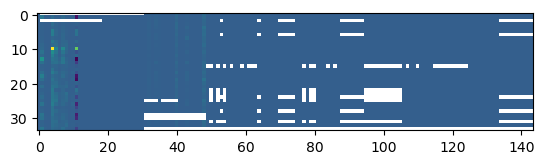

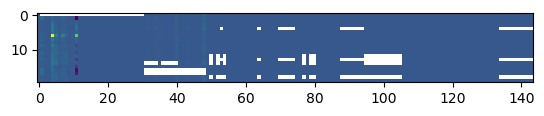

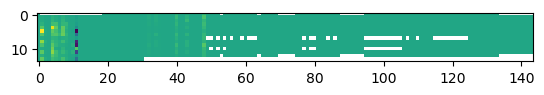

(20, 144) (14, 144) (0,)


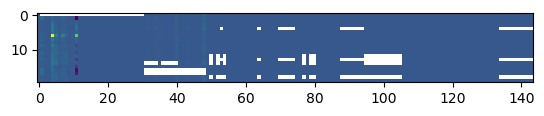

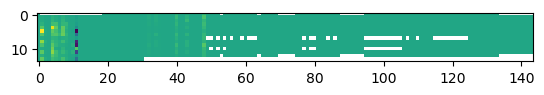

(20, 144) (14, 144) (0,)
(14, 144) (14, 144)
(29, 144)


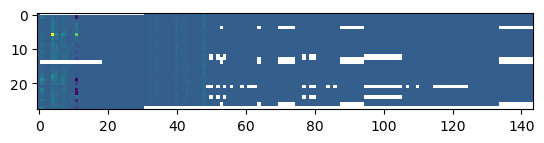

In [239]:
#Orgaize samples by type and format to work with many of the following code->
plt.imshow(np.array(Array_in[1:,:],dtype=float))
plt.show()

Healthy_data=[]
Cancerous_data=[]

#Assign 0 to healthy samples, 1 to cancerous and 2 to Barretts->
for i in range(Array_in.shape[0]-1):
    if Array_in[i+1,0]==0:
        Healthy_data.append(Array_in[i+1,:])
    elif Array_in[i+1,0]==2:
        Barretts_data.append(Array_in[i+1,:])
    else:
        Cancerous_data.append(Array_in[i+1,:])

Healtharray=np.array(Healthy_data)
Cancarray=np.array(Cancerous_data)


plt.imshow(np.array(Healtharray,dtype=float))
plt.show()

plt.imshow(np.array(Cancarray,dtype=float))
plt.show()

print(Healtharray.shape, Cancarray.shape, Barrettsarray.shape)

healthmeans=np.nanmean(Healtharray, axis=0)
cancmeans=np.nanmean(Cancarray, axis=0)

plt.imshow(np.array(Healtharray,dtype=float))
plt.show()
plt.imshow(np.array(Cancarray,dtype=float))
plt.show()

print(Healtharray.shape,Cancarray.shape,Barrettsarray.shape)

#Take feature names seperately->
labels=Array_in[0,:].reshape(1, len(Array_in[0,:]))

#Option to only take some of the healthy data to even things out, by taking only part of the arrays below-
#There's likely a more "fair" way to do this but for now I think the later data is more self consistent so I'm going to favor that-
Partial_Healthy_Array=Healtharray[:partialindex,:]
Partial_Canc_Array=Cancarray[:partialindex,:]

print(Partial_Healthy_Array.shape,Partial_Canc_Array.shape)

masterfile=np.concatenate((labels,Partial_Healthy_Array,Partial_Canc_Array))

print(masterfile.shape)

f=plt.imshow(np.array(masterfile[1:,:],dtype=float))
plt.show()

[1, 2]
[3, 4]
[6, 7]
[8, 9]
[10, 11]
[12, 13]
[25, 26]
[27, 28]
[0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1]


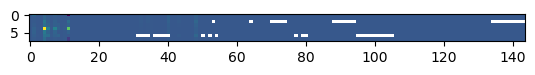

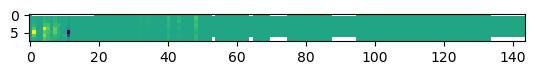

[0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1]


In [240]:
#First we need to organize into two arrays divided up by patient-
#Paired Pats defined above

#Now going to do a super similar thing to what we did for the whole data set dividing the data into two arrays-

Healthy_data_paired=[]
Cancerous_data_paired=[]

#Dependent on the Normal sample coming befor the Tumor sample in the excel doc, a small price to pay for slightly less coding->
for i in range(len(paired_pats)):
    patient=paired_pats[i]
    #print(patient)
    #Find index of that patient data in order patient list-
    pat_indexlist=[j for j,x in enumerate(ordered_patID) if x==patient]
    print(pat_indexlist)
    #Healthy data will be first index in list-
    healthy_index=pat_indexlist[0]
    Healthy_data_paired.append(Array_in[healthy_index+1,:])
    #Cancerous data will be the last index in list (Barrets data not used here for not)-
    canc_index=pat_indexlist[-1]
    Cancerous_data_paired.append(Array_in[canc_index+1,:])
    
Healtharray_paired=np.array(Healthy_data_paired)
Cancarray_paired=np.array(Cancerous_data_paired)

#Check to make sure the two tissue types are properly divided->
print(Healtharray_paired[:,0])
print(Cancarray_paired[:,0])

healthmeans=np.nanmean(Healtharray_paired, axis=0)
healthformatfix=np.array(Healtharray_paired, dtype=np.float64)
healthstdevs=np.nanstd(healthformatfix, axis=0)
cancmeans=np.nanmean(Cancarray_paired, axis=0)
cancformatfix=np.array(Cancarray_paired, dtype=np.float64)
cancstdevs=np.nanstd(cancformatfix, axis=0)

plt.imshow(np.array(Healtharray_paired,dtype=float))
plt.show()

plt.imshow(np.array(Cancarray_paired,dtype=float))
plt.show()

print(Healtharray_paired[:,0],Cancarray_paired[:,0])

Paired Sig Feats-
hiii [0.015625, 0.015625, 0.6875, 0.046875, 0.578125, 0.15625, 0.296875, 0.9375, 0.578125, 0.296875, 0.078125, 0.015625, 0.296875, 0.21875, 0.046875, 0.9375, 0.015625, 0.015625]
[0.05625 0.05625 0.05625 0.05625 0.05625]
hiii [0.1484375, 0.1953125, 0.3125, 0.3125, 0.9453125, 0.0234375, 0.0234375, 0.078125, 0.1484375, 0.109375, 1.0, 0.640625]
[]
hiii [0.15625, 0.296875, 0.8125, 0.578125, 0.0390625, 0.296875, 0.9375, 0.6875, 0.078125, 0.578125, 0.0390625, 0.0078125, 0.0390625, 0.546875, 0.1484375, 0.0390625, 0.0390625, 0.9453125]
[]
hiii [0.015625, 0.8125, 0.4609375, 0.9375, 0.0625, 0.015625, 0.4609375, 0.7421875, 0.25, 0.3125, 0.640625, 0.015625, 0.9453125, 0.3125, 0.078125, 0.625, 0.109375, 0.7421875, 0.4609375, 0.0390625, 0.9453125, 0.4375, 0.625, 1.0, 0.625, 0.1875, 0.3125, 0.9453125, 0.578125, 0.0078125, 0.8125, 0.578125, 0.84375, 0.9453125, 0.1953125, 0.7421875, 1.0, 0.3125, 0.4609375, 0.625, 0.0625, 0.1875, 0.3125, 1.0, 0.0625, 0.4375, 0.15625, 0.8125, 0.375, 0.57

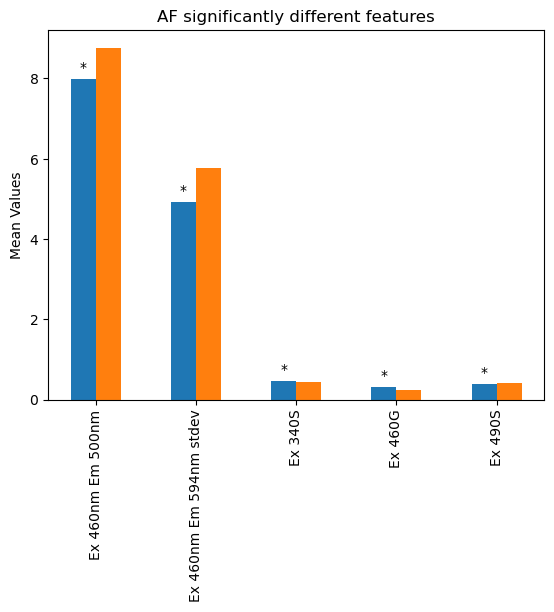

Unpaired Sig Feats-
hiii [0.1239358056727424, 0.027445099375459536, 0.13696741226229456, 0.0577704316108834, 0.6816178642730836, 0.3298783320498747, 0.44175632742491955, 0.5383007490187228, 1.0, 0.08123065302087974, 0.01594131251480136, 0.024044949905367985, 0.18242243945173575, 0.4119238236601619, 0.06486987027995908, 1.0, 0.008912702937838354, 0.018325521931295465]
[0.09880236 0.09880236 0.09880236 0.09880236 0.09880236]
hiii [0.2159322942283799, 0.0347819484147747, 0.10402917405726314, 0.030818058229215455, 0.09891404654662708, 0.0347819484147747, 0.004528632847483328, 0.039173308961157845, 0.0941006375466181, 0.010845950917060442, 0.512401349804485, 0.16666623948362103]
[0.07834662 0.07834662 0.07834662 0.05434359 0.07834662 0.06507571]
hiii [0.7158981921466268, 0.16666623948362103, 0.39576568734555584, 0.6447996764288364, 0.06879998796556563, 0.865134745405447, 0.15228075837759508, 0.15228075837759508, 0.04402679859151475, 0.1820500814244328, 0.27490406320117466, 0.000434572380980

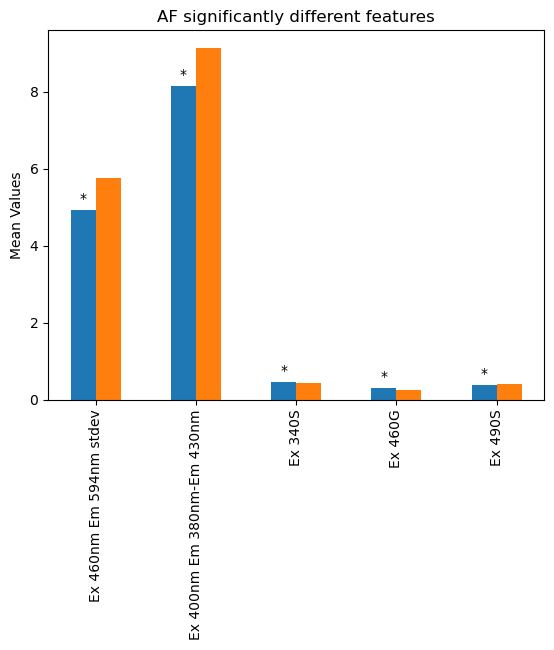

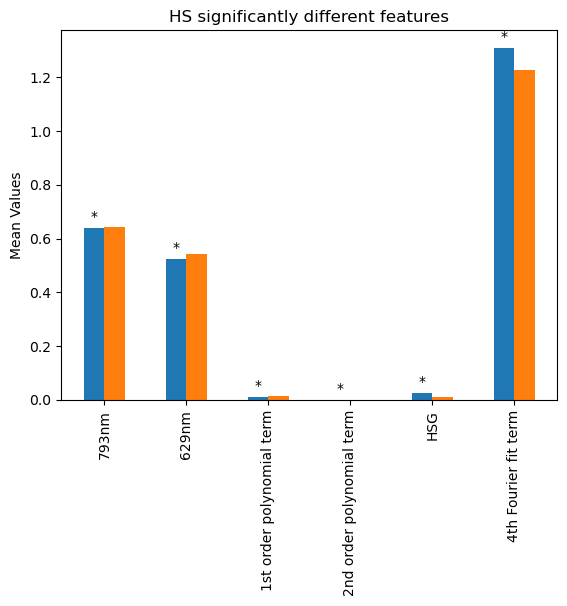

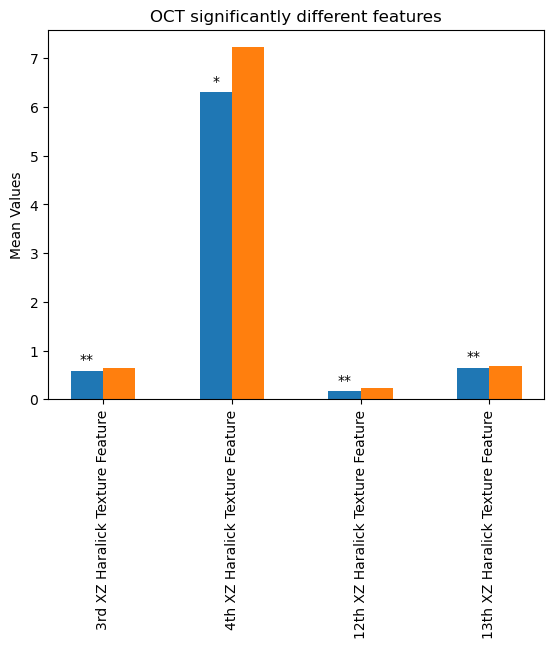

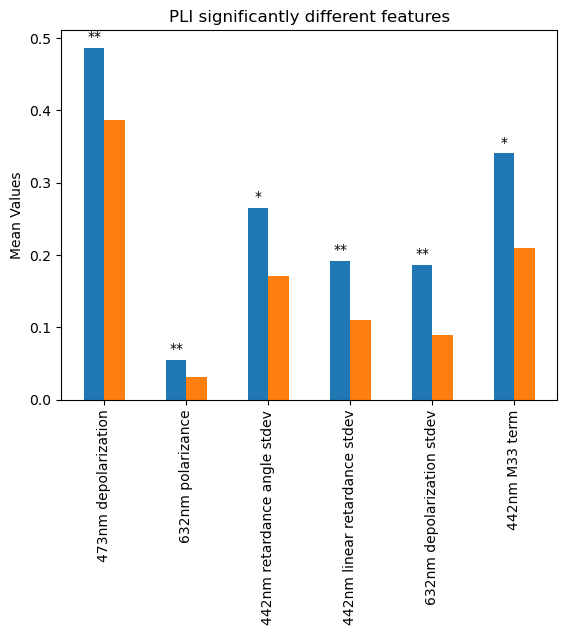

In [241]:
#Paired tests->
print("Paired Sig Feats-")
allwpvalues, AFWSSindicies, HSWSSindicies, OCTWSSindicies, PLIWSSindicies, AllWSSindicies=SSFeatureOrg(wilcoxon)

#allpvalues, AFSSindicies, HSSSindicies, OCTSSindicies,PLISSindicies,AllSSindicies=SSFeatureOrg(ttest_rel)

#unpaired tests->
print("Unpaired Sig Feats-")
allmwpvalues, AFMWSSindicies, HSMWSSindicies, OCTMWSSindicies, PLIMWSSindicies, AllMWSSindicies=SSFeatureOrg(mannwhitneyu,"n")

#allupvalues, AFUSSindicies, HSUSSindicies, OCTUSSindicies, PLIUSSindicies, AllUSSindicies= SSFeatureOrg(ttest_rel,"n")

#joint indicies-
AFSSallI=list(set(AFWSSindicies).union(set(AFMWSSindicies)))
HSSSallI=list(set(HSWSSindicies).union(set(HSMWSSindicies)))
OCTSSallI=list(set(OCTWSSindicies).union(set(OCTMWSSindicies)))
PLISSallI=list(set(PLIWSSindicies).union(set(PLIMWSSindicies)))

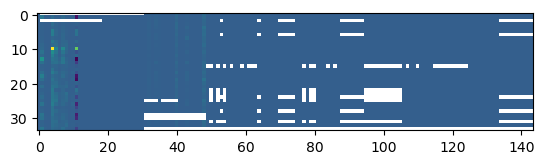

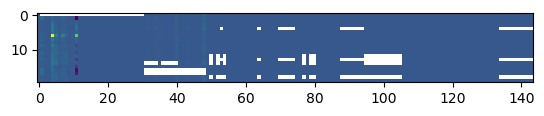

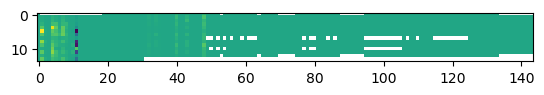

(20, 144) (14, 144) (0,)


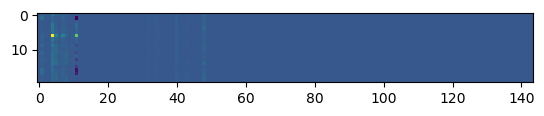

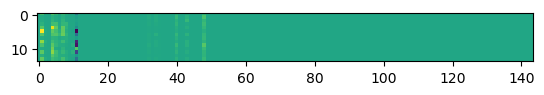

(20, 144) (14, 144) (0,)
(14, 144) (14, 144)
(29, 144)


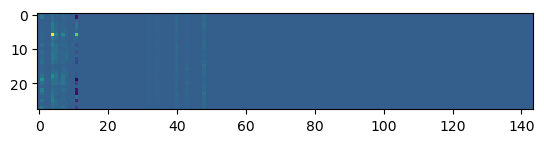

In [242]:
#Reorgaizing data without nans-
plt.imshow(np.array(Array_in[1:,:],dtype=float))
plt.show()

Healthy_data=[]
Cancerous_data=[]

#Assign 0 to healthy samples, 1 to cancerous and 2 to Barretts->
for i in range(Array_in.shape[0]-1):
    if Array_in[i+1,0]==0:
        Healthy_data.append(Array_in[i+1,:])
    elif Array_in[i+1,0]==2:
        Barretts_data.append(Array_in[i+1,:])
    else:
        Cancerous_data.append(Array_in[i+1,:])

Healtharray=np.array(Healthy_data)
Cancarray=np.array(Cancerous_data)

plt.imshow(np.array(Healtharray,dtype=float))
plt.show()
plt.imshow(np.array(Cancarray,dtype=float))
plt.show()


print(Healtharray.shape, Cancarray.shape, Barrettsarray.shape)

healthmeans=np.nanmean(Healtharray, axis=0)
cancmeans=np.nanmean(Cancarray, axis=0)

#*** Handling for missing values- filling in missing vals with means *** ->
for i in range(Array_in.shape[1]-1):
    hline=Healtharray[:,i+1]
    Healtharray[:,i+1]=np.where(np.isnan(hline.astype('float64')),healthmeans[i+1],hline)
    
    cline=Cancarray[:,i+1]
    Cancarray[:,i+1]=np.where(np.isnan(cline.astype('float64')),cancmeans[i+1],cline)
    

plt.imshow(np.array(Healtharray,dtype=float))
plt.show()
plt.imshow(np.array(Cancarray,dtype=float))
plt.show()

print(Healtharray.shape,Cancarray.shape,Barrettsarray.shape)

#Take feature names seperately->
labels=Array_in[0,:].reshape(1, len(Array_in[0,:]))

#Option to only take some of the healthy data to even things out, by taking only part of the arrays below-
#There's likely a more "fair" way to do this but for now I think the later data is more self consistent so I'm going to favor that-
Partial_Healthy_Array=Healtharray[:partialindex,:]
Partial_Canc_Array=Cancarray[:partialindex,:]

print(Partial_Healthy_Array.shape,Partial_Canc_Array.shape)

masterfile=np.concatenate((labels,Partial_Healthy_Array,Partial_Canc_Array))

print(masterfile.shape)

f=plt.imshow(np.array(masterfile[1:,:],dtype=float))
plt.show()

In [243]:
#Let's get classifying! First organizing the data a bit-
#Y is binary classification type-
y=masterfile[1:,0].astype('float64')

#All Features from each imaging type-
All=masterfile[:,1:]
AF=masterfile[:,AF_indicies[0]:AF_indicies[1]]
HS=masterfile[:,HS_indicies[0]:HS_indicies[1]]
OCT=masterfile[:,OCT_indicies[0]:OCT_indicies[1]]
PLI=masterfile[:,PLI_indicies[0]:PLI_indicies[1]]


In [244]:
#Fnc which runs the Random Forrest Classifier and plots top features->
def run_ROC_Class(datain):
    #model = LogisticRegression(penalty='l2',solver='newton-cg',max_iter=10000)
    model = RandomForestClassifier(n_estimators=100)
    #model = GaussianNB()
    #model = KNeighborsClassifier(n_neighbors=4, algorithm = 'ball_tree', n_jobs=-1)
    scalar = StandardScaler()
        
    pipeline = Pipeline([('scaler', scalar), ('estimator', model)])

    #get feature names-
    names=datain[0,:]
    #get raw data alone-
    X = datain[1:,:].astype('float64')

    kf = LeaveOneOut()
    
    all_y = []
    all_probs=[]
    rank_dict={}
    for train, test in kf.split(X, y):
        all_y.append(y[test])
        all_probs.append(model.fit(X[train], y[train]).predict_proba(X[test])[:,1])
        #print("Features sorted by their score:")
        ranked_feat=sorted(zip(map(lambda X: round(X, 4), model.feature_importances_), names), reverse=True)[:10]
        #combine for all test runs
        for i in range(len(ranked_feat)):
            feat_name=ranked_feat[i][1]
            impurity_value=ranked_feat[i][0]
            if feat_name in rank_dict.keys():
                newval=rank_dict[feat_name]+impurity_value
                rank_dict.update({feat_name:newval})
            else:
                rank_dict[feat_name]=impurity_value
    sorted_dict = dict(sorted(rank_dict.items(), key=lambda x: x[1], reverse=True)[:20])
    
    #plot the top features->
    best_feat_names=list(sorted_dict.keys())
#     plt.bar(*zip(*sorted_dict.items()))
#     plt.xticks(rotation=90)
#     plt.ylabel("Total Impurity Reduction")
#     plt.show()
    
    all_y = np.array(all_y)
    all_probs = np.array(all_probs)
    print(all_probs)
    fpr, tpr, thresholds = roc_curve(all_y,all_probs)
    print(fpr, tpr)
    roc_auc = auc(fpr, tpr)
    return(fpr, tpr, roc_auc, best_feat_names)

In [245]:
fpr1, tpr1, roc_auc1, best_feat_namesAll = run_ROC_Class(All)
fpr1, tpr1, roc_auc1, best_feat_namesAF = run_ROC_Class(AF)
fpr2, tpr2, roc_auc2, best_feat_namesHS = run_ROC_Class(HS)
fpr3, tpr3, roc_auc3, best_feat_namesOCT = run_ROC_Class(OCT)
fpr4, tpr4, roc_auc4, best_feat_namesPLI = run_ROC_Class(PLI)

best5All=best_feat_namesAll[:5]
best3AF=best_feat_namesAF[:3]
best3HS=best_feat_namesHS[:3]
best3OCT=best_feat_namesOCT[:3]
best3PLI=best_feat_namesPLI[:3]

[[0.54]
 [0.48]
 [0.46]
 [0.3 ]
 [0.26]
 [0.37]
 [0.22]
 [0.16]
 [0.24]
 [0.61]
 [0.21]
 [0.52]
 [0.16]
 [0.48]
 [0.37]
 [0.49]
 [0.77]
 [0.4 ]
 [0.49]
 [0.76]
 [0.91]
 [0.91]
 [0.89]
 [0.72]
 [0.73]
 [0.68]
 [0.52]
 [0.87]]
[0.         0.         0.         0.14285714 0.21428571 0.21428571
 0.35714286 0.42857143 0.42857143 0.5        0.85714286 1.        ] [0.         0.14285714 0.64285714 0.64285714 0.71428571 0.85714286
 0.85714286 0.85714286 0.92857143 1.         1.         1.        ]
[[0.37]
 [0.92]
 [0.47]
 [0.46]
 [0.24]
 [0.07]
 [0.19]
 [0.23]
 [0.22]
 [0.47]
 [0.32]
 [0.54]
 [0.15]
 [0.33]
 [0.74]
 [0.74]
 [0.73]
 [0.5 ]
 [0.67]
 [0.87]
 [0.9 ]
 [0.77]
 [0.89]
 [0.4 ]
 [0.13]
 [0.33]
 [0.21]
 [0.84]]
[0.         0.07142857 0.07142857 0.07142857 0.07142857 0.14285714
 0.14285714 0.28571429 0.35714286 0.35714286 0.42857143 0.5
 0.78571429 0.78571429 0.92857143 0.92857143 1.        ] [0.         0.         0.35714286 0.5        0.64285714 0.64285714
 0.71428571 0.71428571 0.7142

In [246]:
best10All=best_feat_namesAll[:10]

In [247]:
fpr1, tpr1, roc_auc1, best_feat_namesAll = run_ROC_Class(All)

[[0.5 ]
 [0.46]
 [0.43]
 [0.33]
 [0.22]
 [0.38]
 [0.2 ]
 [0.19]
 [0.19]
 [0.7 ]
 [0.24]
 [0.52]
 [0.13]
 [0.3 ]
 [0.34]
 [0.44]
 [0.74]
 [0.51]
 [0.55]
 [0.75]
 [0.9 ]
 [0.84]
 [0.93]
 [0.64]
 [0.64]
 [0.61]
 [0.51]
 [0.85]]
[0.         0.         0.         0.07142857 0.07142857 0.07142857
 0.14285714 0.14285714 0.28571429 0.28571429 0.42857143 0.42857143
 0.78571429 0.92857143 1.        ] [0.         0.07142857 0.42857143 0.42857143 0.57142857 0.71428571
 0.71428571 0.85714286 0.85714286 0.92857143 0.92857143 1.
 1.         1.         1.        ]


In [248]:
print(best5All)

['normOCTY_H13', 'normOCTY_H12', 'PLI442_linret_std', 'normOCTY_H3', 'PLI632_depol_std']


[[0.33]
 [0.96]
 [0.64]
 [0.42]
 [0.25]
 [0.12]
 [0.19]
 [0.28]
 [0.27]
 [0.56]
 [0.31]
 [0.46]
 [0.2 ]
 [0.39]
 [0.77]
 [0.69]
 [0.7 ]
 [0.51]
 [0.51]
 [0.8 ]
 [0.85]
 [0.75]
 [0.82]
 [0.37]
 [0.17]
 [0.43]
 [0.22]
 [0.76]]
[0.         0.07142857 0.07142857 0.21428571 0.21428571 0.28571429
 0.28571429 0.42857143 0.42857143 0.78571429 0.78571429 0.92857143
 0.92857143 1.        ] [0.         0.         0.57142857 0.57142857 0.71428571 0.71428571
 0.78571429 0.78571429 0.85714286 0.85714286 0.92857143 0.92857143
 1.         1.        ]
['ILL460G' 'ILL490S' 'bpILL400_380_430' 'ILL340S' 'ILL400G'
 'ILL460_594_stdev' 'bpILL340_380_430' 'ILL340_647_stdev' 'ILL460_500'
 'ILL340G' 'ILL400_380' 'ILL640_380_stdev' 'ILL400S' 'ILL400_380_stdev'
 'ILL400_594_stdev']
[[0.44]
 [0.92]
 [0.59]
 [0.55]
 [0.14]
 [0.03]
 [0.1 ]
 [0.1 ]
 [0.12]
 [0.6 ]
 [0.24]
 [0.6 ]
 [0.09]
 [0.51]
 [0.79]
 [0.82]
 [0.69]
 [0.64]
 [0.7 ]
 [0.84]
 [0.87]
 [0.83]
 [0.84]
 [0.24]
 [0.09]
 [0.42]
 [0.24]
 [0.77]]
[0.       

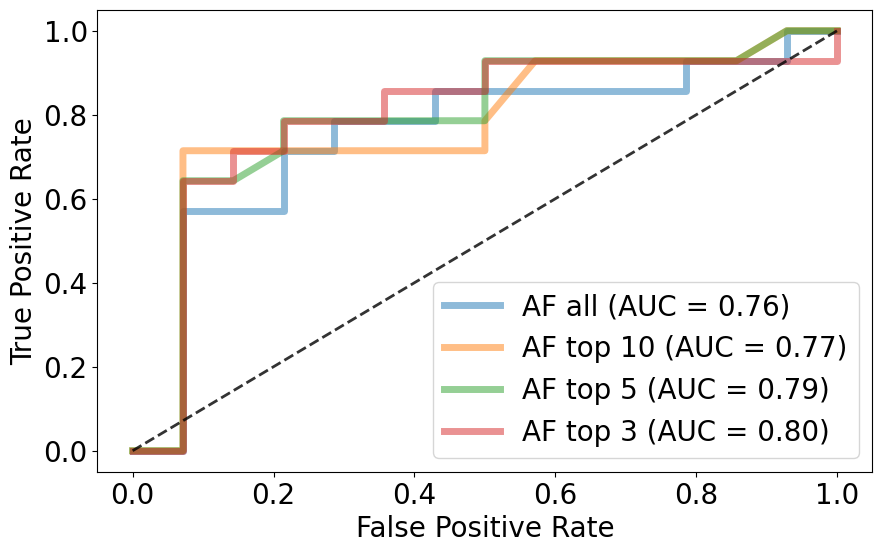

[[0.26]
 [0.72]
 [0.27]
 [0.23]
 [0.49]
 [0.36]
 [0.39]
 [0.37]
 [0.43]
 [0.52]
 [0.19]
 [0.29]
 [0.47]
 [0.5 ]
 [0.12]
 [0.3 ]
 [0.53]
 [0.55]
 [0.34]
 [0.91]
 [0.95]
 [0.94]
 [0.99]
 [0.19]
 [0.78]
 [0.76]
 [0.56]
 [0.94]]
[0.         0.         0.         0.         0.         0.07142857
 0.07142857 0.64285714 0.64285714 0.92857143 1.         1.        ] [0.         0.07142857 0.14285714 0.28571429 0.5        0.5
 0.71428571 0.71428571 0.85714286 0.85714286 0.92857143 1.        ]
['HS_param2' 'HSF_4' 'HSF_3' 'HSG' 'HS_param1' 'HS594_stdev' 'HS629'
 'HS793' 'HSF_6' 'HS542' 'HSF_5' 'HS880']
[[0.23]
 [0.75]
 [0.26]
 [0.18]
 [0.45]
 [0.33]
 [0.27]
 [0.27]
 [0.48]
 [0.59]
 [0.23]
 [0.28]
 [0.51]
 [0.45]
 [0.12]
 [0.25]
 [0.69]
 [0.46]
 [0.39]
 [0.78]
 [0.99]
 [0.9 ]
 [0.99]
 [0.28]
 [0.85]
 [0.68]
 [0.59]
 [0.99]]
[0.         0.         0.         0.07142857 0.07142857 0.14285714
 0.28571429 0.28571429 0.42857143 0.42857143 0.5        0.57142857
 0.71428571 0.78571429 0.78571429 0.928571

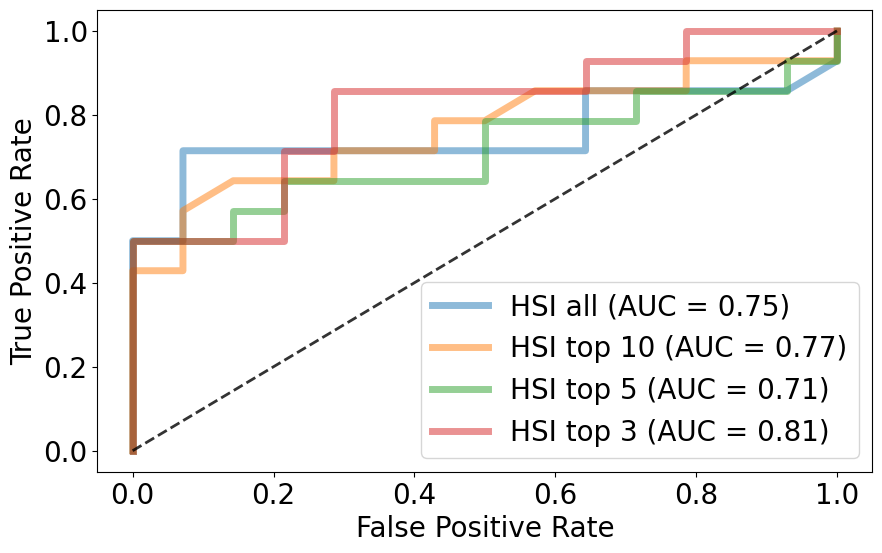

[[0.26]
 [0.23]
 [0.22]
 [0.29]
 [0.2 ]
 [0.08]
 [0.21]
 [0.33]
 [0.24]
 [0.9 ]
 [0.25]
 [0.17]
 [0.12]
 [0.27]
 [0.14]
 [0.63]
 [0.9 ]
 [0.45]
 [0.85]
 [0.8 ]
 [0.7 ]
 [0.92]
 [0.89]
 [0.6 ]
 [0.7 ]
 [0.62]
 [0.62]
 [0.85]]
[0.         0.         0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.85714286 0.85714286
 1.        ] [0.         0.07142857 0.14285714 0.21428571 0.35714286 0.42857143
 0.57142857 0.64285714 0.78571429 0.92857143 0.92857143 1.
 1.        ]
['normOCTY_H12' 'normOCTY_H13' 'normOCTY_H3' 'normOCTY_H6' 'OCT_freq2'
 'normOCTY_H4' 'normOCT_H12' 'OCT_atten' 'normOCT_H13' 'OCTY_freq1'
 'OCT_freq7' 'normOCT_H3' 'normOCT_H4' 'normOCT_H10' 'normOCTY_H1'
 'normOCT_H1' 'normOCTY_H10']
[[0.3 ]
 [0.15]
 [0.12]
 [0.39]
 [0.08]
 [0.07]
 [0.19]
 [0.14]
 [0.33]
 [0.97]
 [0.26]
 [0.09]
 [0.1 ]
 [0.3 ]
 [0.03]
 [0.7 ]
 [0.94]
 [0.49]
 [0.94]
 [0.87]
 [0.93]
 [0.97]
 [0.87]
 [0.6 ]
 [0.82]
 [0.59]
 [0.67]
 [0.89]]
[0.         0.07142857 0.071

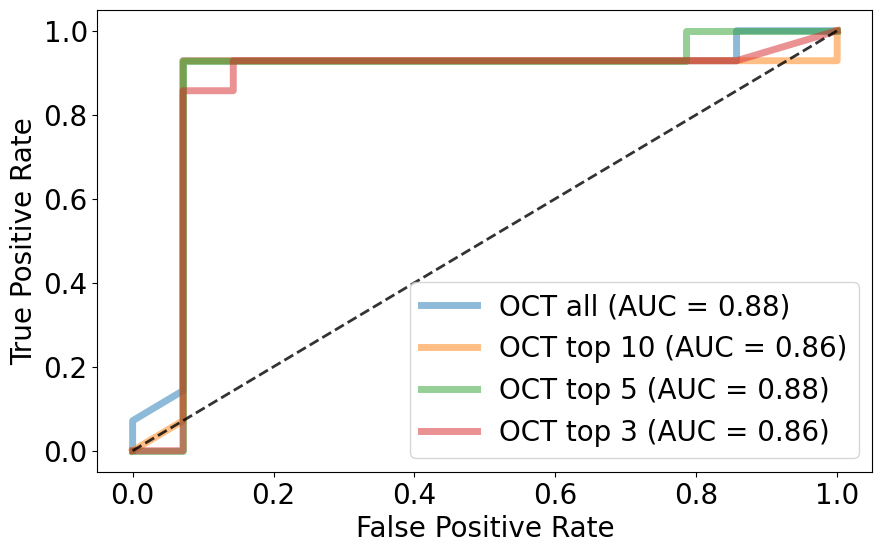

[[0.72]
 [0.33]
 [0.44]
 [0.3 ]
 [0.32]
 [0.52]
 [0.27]
 [0.24]
 [0.15]
 [0.49]
 [0.31]
 [0.64]
 [0.23]
 [0.3 ]
 [0.52]
 [0.41]
 [0.7 ]
 [0.47]
 [0.46]
 [0.7 ]
 [0.94]
 [0.81]
 [0.83]
 [0.76]
 [0.78]
 [0.55]
 [0.44]
 [0.75]]
[0.         0.         0.         0.07142857 0.07142857 0.14285714
 0.14285714 0.21428571 0.28571429 0.28571429 0.35714286 0.35714286
 0.57142857 0.71428571 1.        ] [0.         0.07142857 0.42857143 0.42857143 0.57142857 0.57142857
 0.64285714 0.71428571 0.71428571 0.85714286 0.92857143 1.
 1.         1.         1.        ]
['PLI442_linret_std' 'PLI632_polar' 'PLI632_depol_std' 'PLI632_linret'
 'PLI473_depol' 'PLI405_optrot_std' 'PLI473_m44' 'PLI632_cdia'
 'PLI442_retang_std' 'PLI405_m34' 'PLI405_m24' 'PLI405_m31' 'PLI632_m31'
 'PLI405_cdia' 'PLI442_m33' 'PLI405_m14' 'PLI405_m43' 'PLI543_m34'
 'PLI632_ret' 'PLI632_diang']
[[0.47]
 [0.6 ]
 [0.31]
 [0.21]
 [0.11]
 [0.4 ]
 [0.15]
 [0.11]
 [0.  ]
 [0.29]
 [0.08]
 [0.64]
 [0.07]
 [0.11]
 [0.67]
 [0.42]
 [0.96]
 [0.5

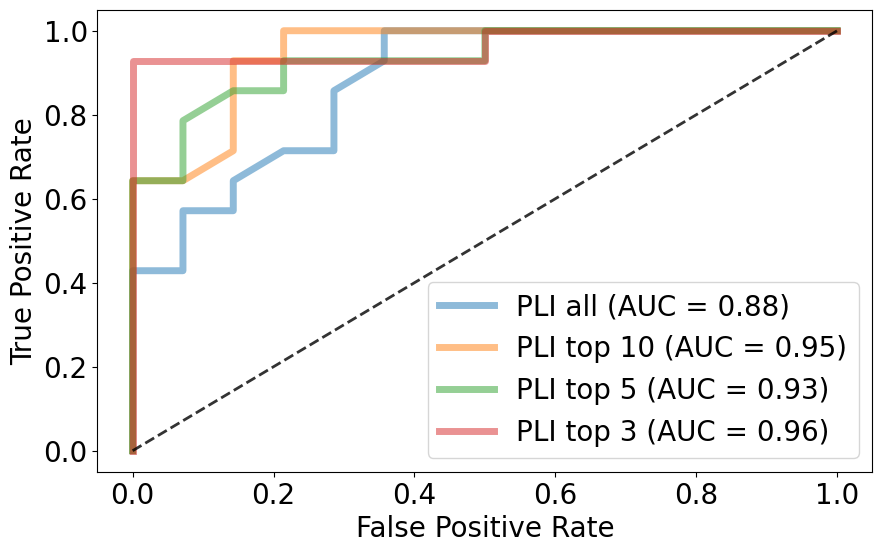

[[0.57]
 [0.47]
 [0.39]
 [0.41]
 [0.21]
 [0.29]
 [0.16]
 [0.17]
 [0.17]
 [0.62]
 [0.23]
 [0.55]
 [0.1 ]
 [0.29]
 [0.35]
 [0.45]
 [0.68]
 [0.45]
 [0.55]
 [0.75]
 [0.92]
 [0.94]
 [0.87]
 [0.7 ]
 [0.71]
 [0.6 ]
 [0.55]
 [0.83]]
[0.         0.         0.         0.07142857 0.07142857 0.14285714
 0.21428571 0.28571429 0.28571429 0.42857143 0.42857143 0.57142857
 0.71428571 0.85714286 1.        ] [0.         0.07142857 0.57142857 0.57142857 0.64285714 0.64285714
 0.78571429 0.78571429 0.92857143 0.92857143 1.         1.
 1.         1.         1.        ]
['normOCTY_H13' 'normOCTY_H12' 'PLI632_depol_std' 'PLI442_linret_std'
 'normOCTY_H3' 'PLI632_polar' 'PLI632_linret' 'PLI473_depol' 'PLI473_m44'
 'HS_param2' 'ILL460G' 'PLI442_retang_std' 'PLI405_optrot_std'
 'PLI632_cdia' 'PLI405_m31' 'PLI405_m34' 'PLI405_cdia' 'PLI405_m24'
 'ILL490S' 'PLI632_ret']
[[0.34]
 [0.44]
 [0.24]
 [0.27]
 [0.2 ]
 [0.19]
 [0.02]
 [0.  ]
 [0.05]
 [0.77]
 [0.03]
 [0.51]
 [0.06]
 [0.09]
 [0.24]
 [0.49]
 [0.9 ]
 [0.48]
 

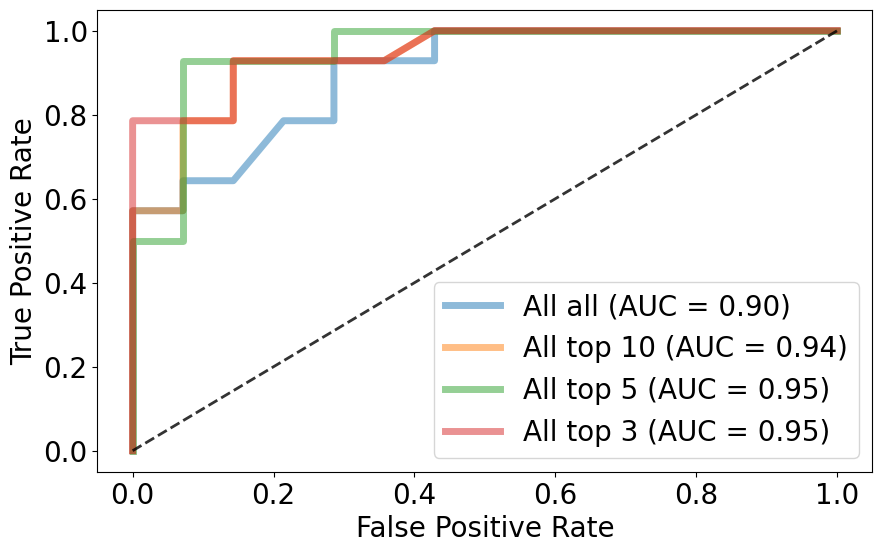

In [249]:
#Run RF and Plot ROC for a mode with different amounts of features-

def RunRfandPlot(dataset, nametag):
    #Run model with all-
    RFfpr0, RFtpr0, RFroc_auc0, RFbest_feat_names0 = run_ROC_Class(dataset)
    #Run with correlation reduced feats-
    #fpr1, tpr1, roc_auc1, best_feat_names1 = run_ROC_Class(PLInew)
    #Top used features-
    rffeats=Sort_From_Index(Indicies_From_Names(RFbest_feat_names0, masterfile),masterfile)
    print(rffeats[0,:])
    #Subsets from top features-
    RFfpr2, RFtpr2, RFroc_auc2, RFbest_feat_names2 = run_ROC_Class(rffeats[:,:10])
    RFfpr3, RFtpr3, RFroc_auc3, RFbest_feat_names3 = run_ROC_Class(rffeats[:,:5])
    RFfpr4, RFtpr4, RFroc_auc4, RFbest_feat_names4 = run_ROC_Class(rffeats[:,:3])
    
    #Plots ROC curves from random forrest classifier->
    plt.figure(1, figsize=(10,6))
    #Labels need to be changed manually but AUC values automatically update
    plt.plot(RFfpr0, RFtpr0, lw=5, alpha=0.5, label=nametag+' all (AUC = %0.2f)' % (RFroc_auc0))
    #plt.plot(fpr1, tpr1, lw=5, alpha=0.5, label='PLI Cor-reduce(AUC = %0.2f)' % (roc_auc1))
    plt.plot(RFfpr2, RFtpr2, lw=5, alpha=0.5, label=nametag+' top 10 (AUC = %0.2f)' % (RFroc_auc2))
    plt.plot(RFfpr3, RFtpr3, lw=5, alpha=0.5, label=nametag+' top 5 (AUC = %0.2f)' % (RFroc_auc3))
    plt.plot(RFfpr4, RFtpr4, lw=5, alpha=0.5, label=nametag+' top 3 (AUC = %0.2f)' % (RFroc_auc4))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.legend(loc='lower right', fontsize=20)
    plt.show()
    
    
    RF10List=[RFfpr2, RFtpr2, RFroc_auc2]
    RF3List=[RFfpr4, RFtpr4, RFroc_auc4]
    
    
    return(RF10List, RF3List)

AFRF10, AFRF3 = RunRfandPlot(AF, "AF")
HSRF10, HSRF3 = RunRfandPlot(HS, "HSI")
OCTRF10, OCTRF3 = RunRfandPlot(OCT, "OCT")
PLIRF10, PLIRF3 = RunRfandPlot(PLI, "PLI")
AllRF10, AllRF3 = RunRfandPlot(All, "All")
    

SW (143, 143) (143, 14) (143, 1)


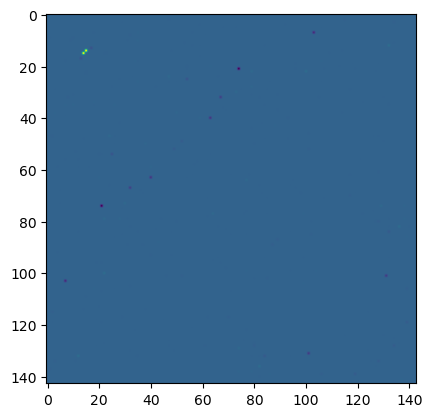

['normOCTY_H12' 'normOCTY_H13' 'PLI473_depol' 'normOCTY_H3' 'PLI632_polar'
 'PLI442_linret_std' 'PLI405_m34' 'PLI632_linret' 'PLI405_m43'
 'PLI405_m22']
SW (18, 18) (18, 14) (18, 1)


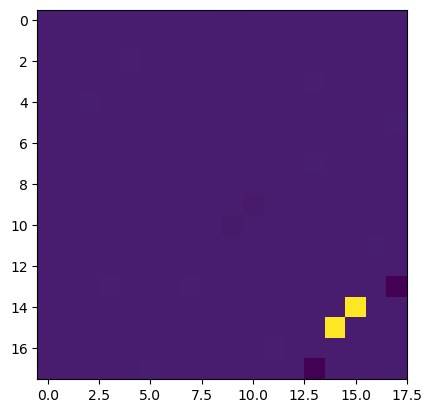

['ILL460_594_stdev' 'ILL460G' 'bpILL400_380_430' 'ILL400G' 'ILL490S'
 'ILL460_500' 'ILL340_647_stdev' 'ILL400_380' 'ILL400S' 'ILL640_380_stdev']
SW (12, 12) (12, 14) (12, 1)


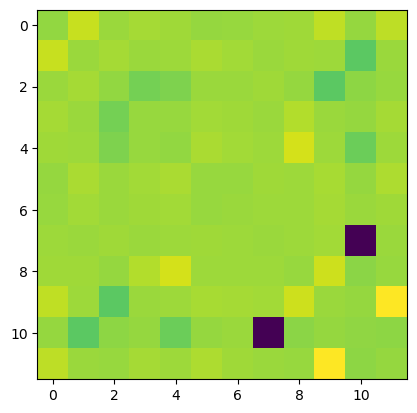

['HSG' 'HSF_4' 'HS_param2' 'HS793' 'HSF_3' 'HS629' 'HS_param1' 'HSF_6'
 'HS880' 'HS542']
SW (18, 18) (18, 14) (18, 1)


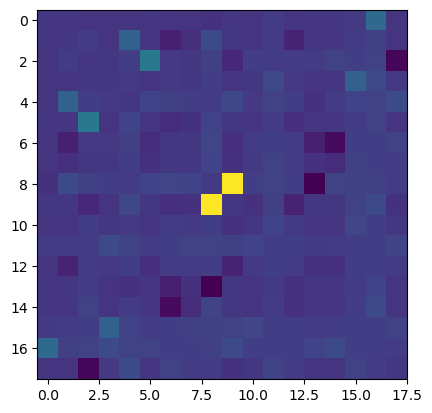

['normOCTY_H12' 'normOCTY_H13' 'normOCTY_H3' 'normOCTY_H4' 'OCT_atten'
 'normOCTY_H6' 'normOCT_H12' 'normOCT_H13' 'normOCTY_H1' 'OCT_freq2']
SW (95, 95) (95, 14) (95, 1)


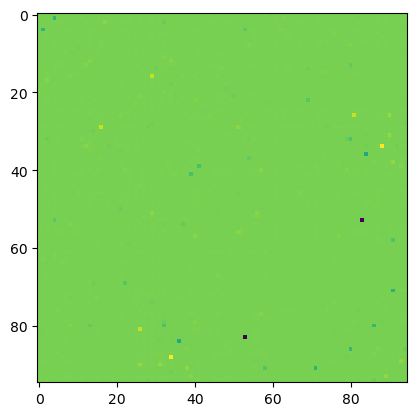

['PLI473_depol' 'PLI632_polar' 'PLI442_linret_std' 'PLI405_m34'
 'PLI632_linret' 'PLI405_m43' 'PLI405_m22' 'PLI632_depol_std' 'PLI632_m13'
 'PLI632_m43']


In [250]:
#Continueing on with LDA process sort by scattering within or between->

#Sw- within class scatter and Sb- between class scatter
#Used first to select features but then also in LDA-
def scatteringreduce(arrayin,num_featout):
    num_feats=arrayin.shape[1]
    
    #Seperate by classes-
    #Assuming the array in has the format- 1 row feature names, x rows healthy, x rows cancer data-
    half_num=int((arrayin.shape[0]-1)/2)
    
    names=arrayin[0,:]
    HealthySet=arrayin[1:half_num+1,:].T
    CancSet=arrayin[half_num+1:,:].T

    Healthymean=np.mean(HealthySet, axis=1).reshape(num_feats,1)
    Cancmean=np.mean(HealthySet, axis=1).reshape(num_feats,1)

    Scatter_Healthy=np.dot((HealthySet-Healthymean),(HealthySet-Healthymean).T)
    Scatter_Canc=np.dot((CancSet-Cancmean),(CancSet-Cancmean).T)

    Sw=np.array(Scatter_Healthy+Scatter_Canc,dtype=float)
    print("SW",Sw.shape, HealthySet.shape, Healthymean.shape)

    Allmean=np.mean(arrayin[1:,:].T, axis=1).reshape(num_feats,1)
    
    Scatter_Between_H=np.dot((Healthymean-Allmean),(Healthymean-Allmean).T)
    Scatter_Between_C=np.dot((Cancmean-Allmean),(Cancmean-Allmean).T)

    ni=HealthySet.shape[0]

    Sb=np.array(ni*(Scatter_Between_H+Scatter_Between_C),dtype=float)
    Sratio=Sb/Sw
    
    plt.imshow(Sratio)
    plt.show()
    
    Seigs=np.diagonal(Sratio)

    topargs=topxargs(Seigs,num_featout)
    topfeats=np.zeros((arrayin.shape[0],len(topargs)),dtype='object')

    for i in range(len(topargs)):
        topfeats[:,i]=arrayin[:,topargs[i]]
    
    print(topfeats[0,:])
    
    return(topfeats)
    
#function to find a given integer x arguments of the x highest values in a 2d array-
def topxargs(givenAr,x):
    toplist=[]
    givenAr.setflags(write=1)
    for i in range(x):
        maxind=np.argmax(givenAr)
        givenAr[maxind]=0
        toplist.append(maxind)
    return(toplist)

#PLISSnew=correduce(All, "n")
Allreduced=scatteringreduce(Allnew,10)
AFreduced=scatteringreduce(AFnew,10)
HSreduced=scatteringreduce(HSnew,10)
OCTreduced=scatteringreduce(OCTnew,10)
PLIreduced=scatteringreduce(PLInew,10)

In [251]:
AFallIresults=list(set(AFSSallI).union(set(Indicies_From_Names(best3AF,masterfile))).union(set(list(Indicies_From_Names(AFreduced[0,:3],masterfile)))))
HSallIresults=list(set(HSSSallI).union(set(Indicies_From_Names(best3HS,masterfile))).union(set(list(Indicies_From_Names(HSreduced[0,:3],masterfile)))))
OCTallIresults=list(set(OCTSSallI).union(set(Indicies_From_Names(best3OCT,masterfile))).union(set(list(Indicies_From_Names(OCTreduced[0,:3],masterfile)))))
PLIallIresults=list(set(PLISSallI).union(set(Indicies_From_Names(best3PLI,masterfile))).union(set(list(Indicies_From_Names(PLIreduced[0,:3],masterfile)))))
print(PLIallIresults)

AllallIresults=list(set(Indicies_From_Names(best5All,masterfile)).union(set(list(Indicies_From_Names(Allreduced[0,:5],masterfile)))))
print(AllallIresults)

[74, 106, 75, 78, 90, 62]
[42, 74, 46, 78, 47, 90, 62]


In [252]:
Best10Ind=Indicies_From_Names(best10All,masterfile)

In [253]:
#Now LDA classifier->
def run_LDA(datain):
    clf = LinearDiscriminantAnalysis(solver="svd")
    
    #get raw data alone-
    X = datain[1:,:].astype('float64')
    kf = LeaveOneOut()
    
    print("X",X.shape)
    print("y",y.shape)
    
    all_y = []
    all_probs=[]
    for train, test in kf.split(X, y):
        all_y.append(y[test])
        all_probs.append(clf.fit(X[train], y[train]).predict_proba(X[test])[:,1])
        
    all_y = np.array(all_y)
    all_probs = np.array(all_probs)
    fpr, tpr, thresholds = roc_curve(all_y,all_probs)
    roc_auc = auc(fpr, tpr)
    return(fpr, tpr, roc_auc)

(29, 18)
(29, 10)
X (28, 18)
y (28,)
X (28, 10)
y (28,)
X (28, 3)
y (28,)


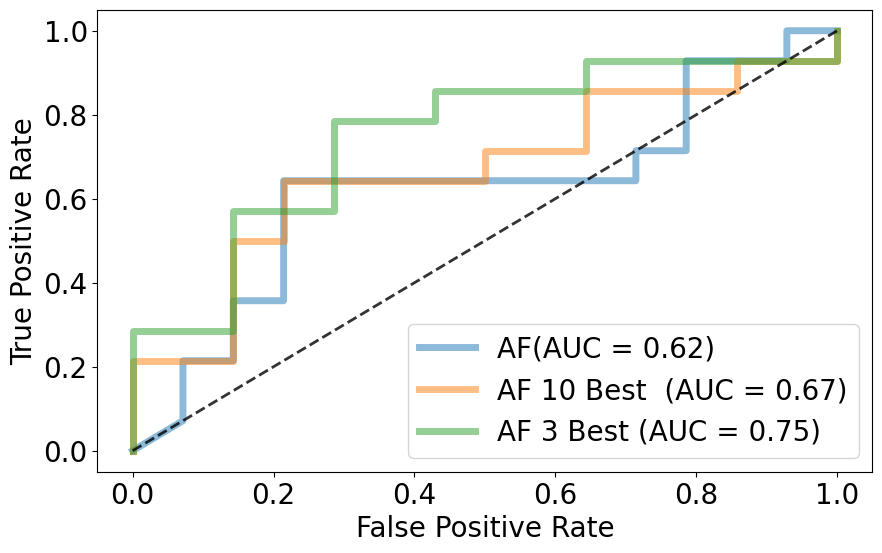

X (28, 12)
y (28,)
X (28, 10)
y (28,)
X (28, 3)
y (28,)


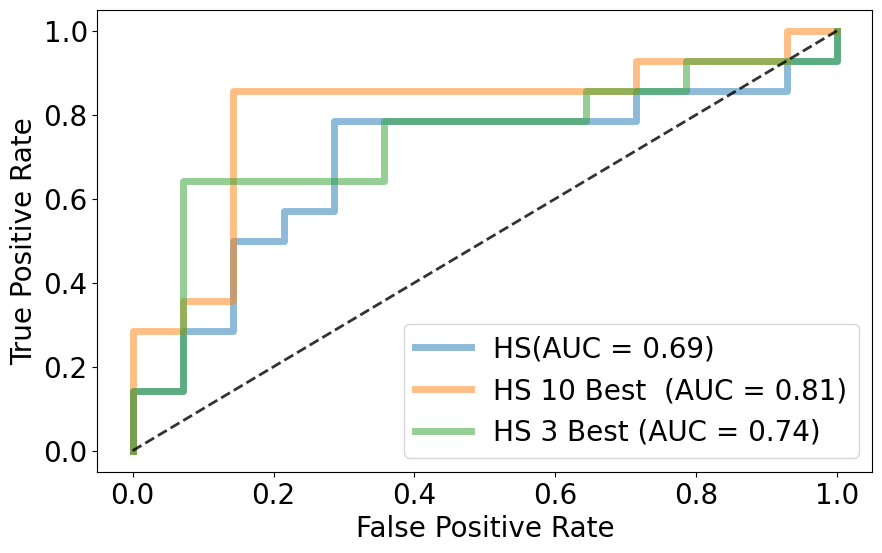

X (28, 18)
y (28,)
X (28, 10)
y (28,)
X (28, 3)
y (28,)


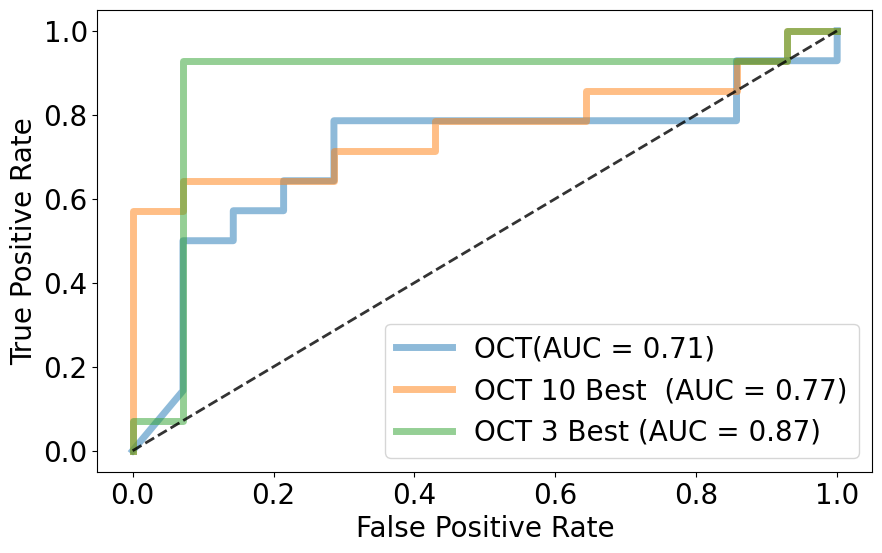

X (28, 95)
y (28,)
X (28, 10)
y (28,)
X (28, 3)
y (28,)


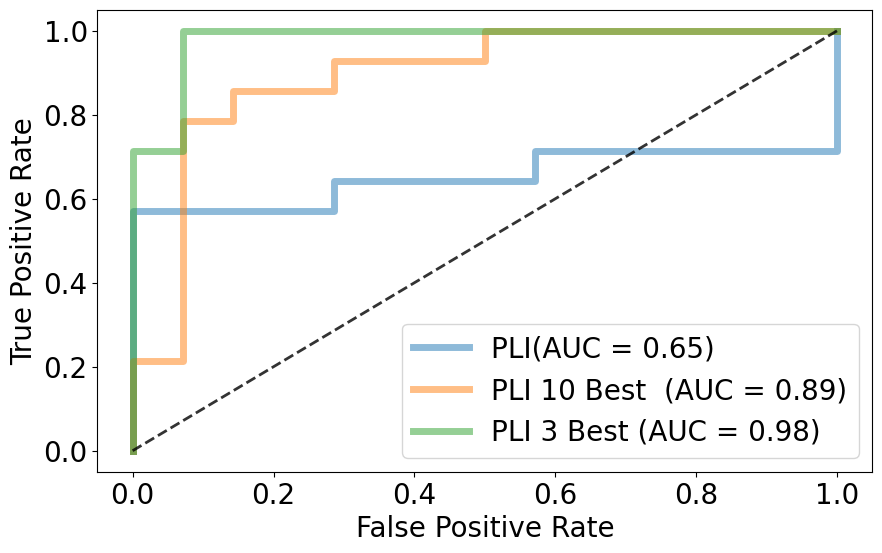

X (28, 143)
y (28,)
X (28, 10)
y (28,)
X (28, 3)
y (28,)


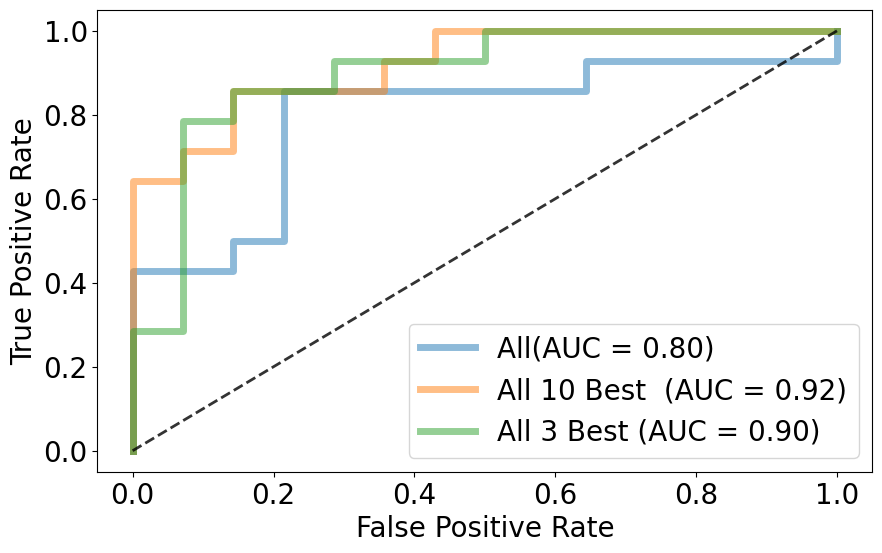

In [254]:
def RunLDAandPlot(dataset, datareducted, nametag):
    LDAfpr1, LDAtpr1, LDAroc_auc1 = run_LDA(dataset)
    LDAfpr2, LDAtpr2, LDAroc_auc2 = run_LDA(datareducted)
    LDAfpr3, LDAtpr3, LDAroc_auc3 = run_LDA(datareducted[:,:3])

    plt.figure(1, figsize=(10,6))
    plt.plot(LDAfpr1, LDAtpr1, lw=5, alpha=0.5, label= nametag + '(AUC = %0.2f)' % (LDAroc_auc1))
    plt.plot(LDAfpr2, LDAtpr2, lw=5, alpha=0.5, label=nametag + ' 10 Best  (AUC = %0.2f)' % (LDAroc_auc2))
    plt.plot(LDAfpr3, LDAtpr3, lw=5, alpha=0.5, label=nametag + ' 3 Best (AUC = %0.2f)' % (LDAroc_auc3))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.legend(loc="lower right", fontsize=20)
    plt.show()
    
    
    LDA10list=[LDAfpr2, LDAtpr2, LDAroc_auc2]
    LDA3list=[LDAfpr3, LDAtpr3, LDAroc_auc3]
    
    return(LDA10list, LDA3list)

print(AF.shape)
print(AFreduced.shape)

AFLDA10, AFLDA3 = RunLDAandPlot(AF, AFreduced, "AF")
HSLDA10, HSLDA3 = RunLDAandPlot(HS, HSreduced, "HS")
OCTLDA10, OCTLDA3 = RunLDAandPlot(OCT, OCTreduced, "OCT")
PLILDA10, PLILDA3 = RunLDAandPlot(PLI, PLIreduced, "PLI")
AllLDA10, AllLDA3 = RunLDAandPlot(All, Allreduced, "All")


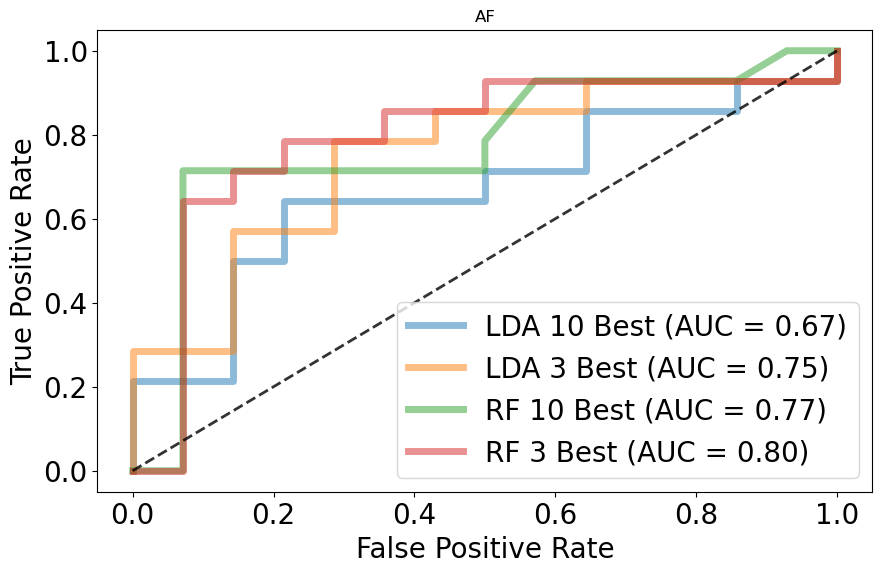

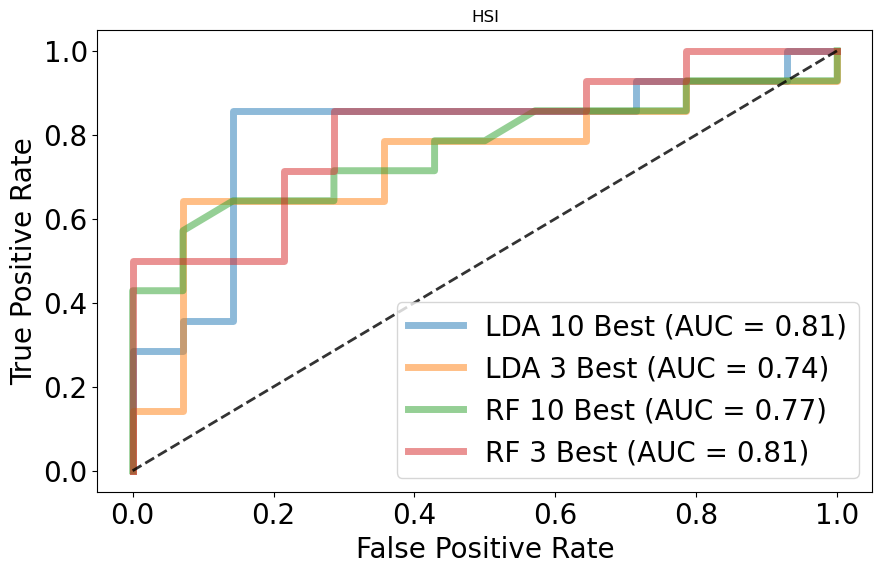

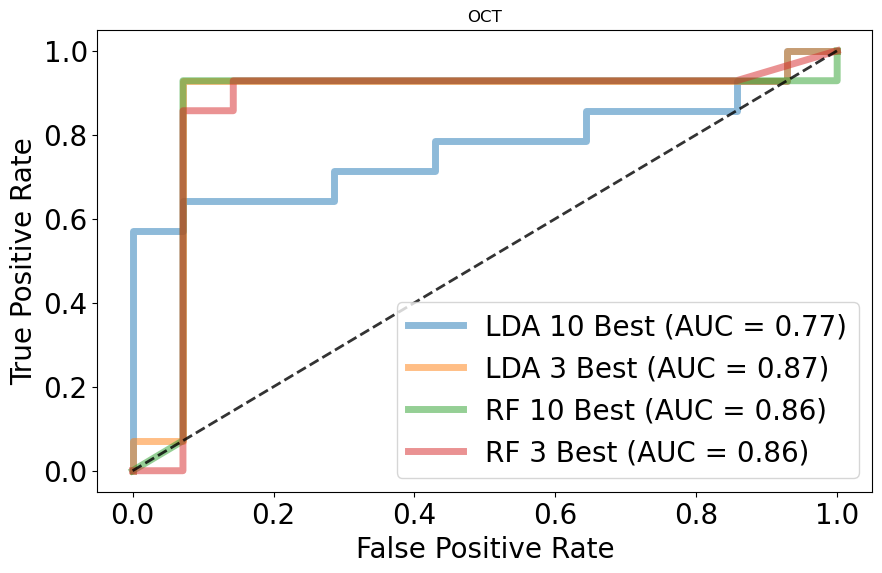

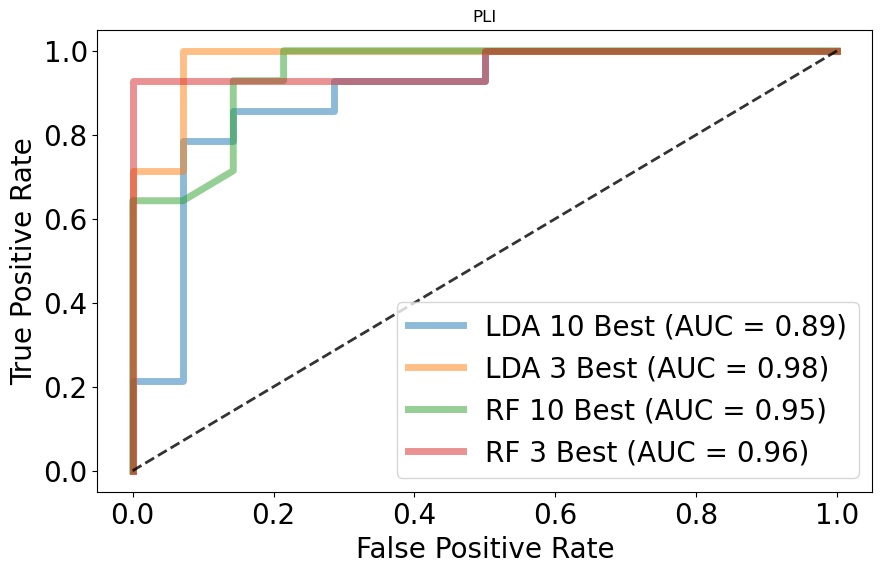

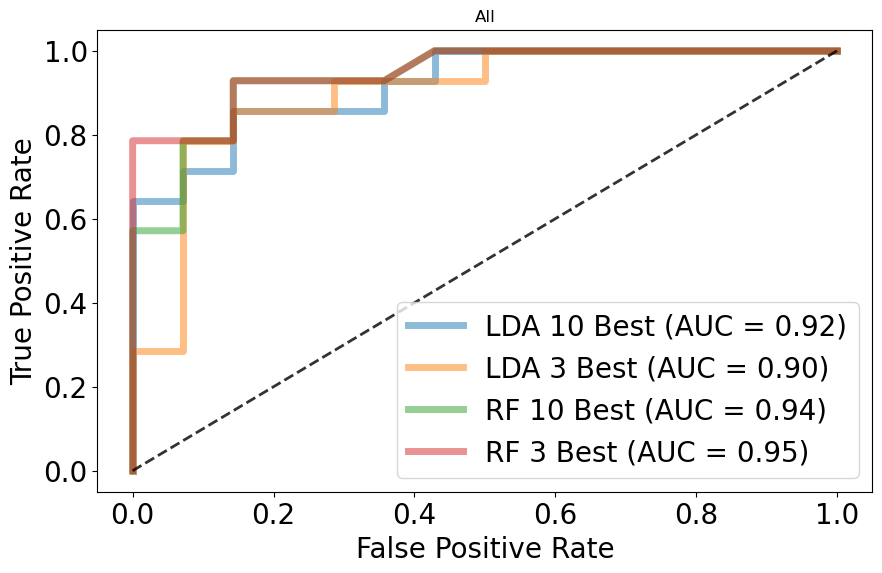

()

In [255]:
#The whole gang-

def RocForAll(LDA10list, LDA3list, RF10list, RF3list, titlestr):
    LDAfpr10,LDAtpr10,LDAroc_auc10=LDA10list
    LDAfpr3,LDAtpr3,LDAroc_auc3=LDA3list
    RFfpr10, RFtpr10, RFroc_auc10= RF10list
    RFfpr3, RFtpr3, RFroc_auc3= RF3list
    
    plt.figure(1, figsize=(10,6))
    plt.plot(LDAfpr10, LDAtpr10, lw=5, alpha=0.5, label='LDA 10 Best (AUC = %0.2f)' % (LDAroc_auc10))
    plt.plot(LDAfpr3, LDAtpr3, lw=5, alpha=0.5, label='LDA 3 Best (AUC = %0.2f)' % (LDAroc_auc3))
    plt.plot(RFfpr10, RFtpr10, lw=5, alpha=0.5, label='RF 10 Best (AUC = %0.2f)' % (RFroc_auc10))
    plt.plot(RFfpr3, RFtpr3, lw=5, alpha=0.5, label='RF 3 Best (AUC = %0.2f)' % (RFroc_auc3))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(titlestr)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.legend(loc="lower right", fontsize=20)
    plt.show()
    
    return()

RocForAll(AFLDA10, AFLDA3, AFRF10, AFRF3, "AF")
RocForAll(HSLDA10, HSLDA3, HSRF10, HSRF3, "HSI")
RocForAll(OCTLDA10, OCTLDA3, OCTRF10, OCTRF3, "OCT")
RocForAll(PLILDA10, PLILDA3, PLIRF10, PLIRF3, "PLI")
RocForAll(AllLDA10, AllLDA3, AllRF10, AllRF3, "All")


[0.98481579 0.12144825 0.32497703 0.35000455 0.99557482 0.67834238
 0.87308506]
5


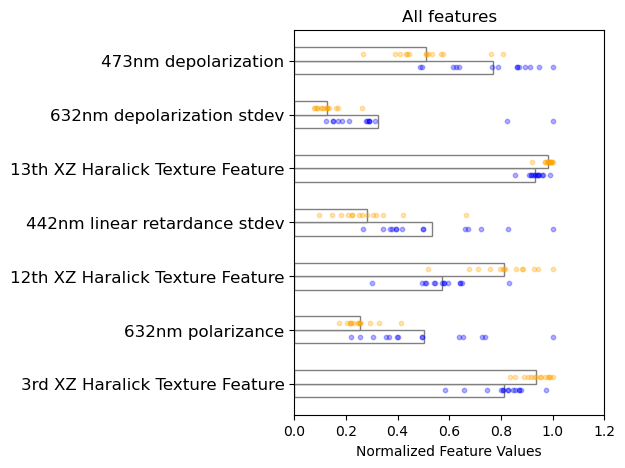

[2.19394095e+04 1.62827169e+03 4.85563844e+04 6.45086369e-01
 5.47207827e-01 5.46596311e-01]
4


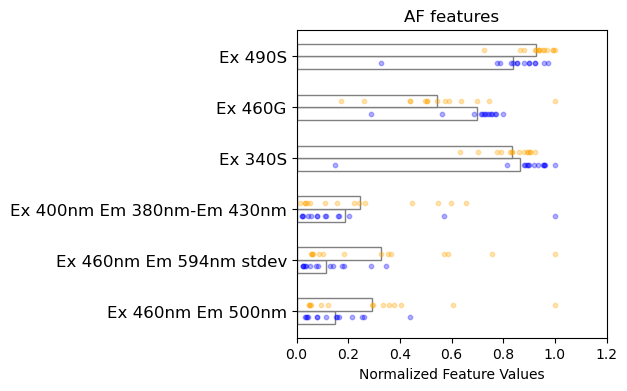

[9.71188579e-01 9.11058507e-01 2.52444910e-02 8.52369674e-04
 6.85739145e-02 3.63944863e+00]
4


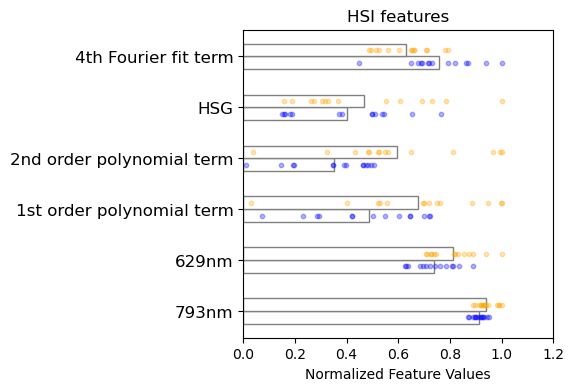

[9.84815791e-01 3.94231889e+03 3.24977035e-01 9.95574824e-01]
2


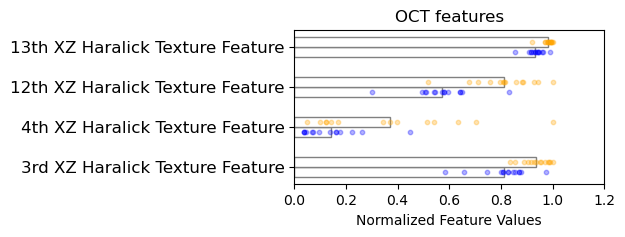

[0.12144825 0.8002073  0.59743429 0.35000455 0.67834238 0.87308506]
4


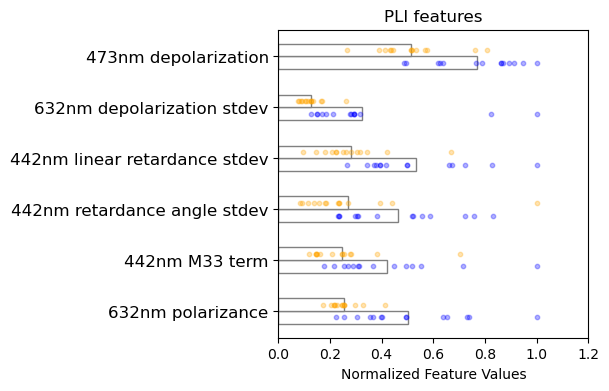

()

In [256]:
#Bar chart with scatter data point->
def featbarchart(arrayin, Title=""):
    names=arrayin[0,:]
    
    farrayin=np.array(arrayin[1:,:], dtype=float)
    print(np.max(np.abs(farrayin),axis=0))
    
    
    farrayin=np.abs(farrayin)/np.max(np.abs(farrayin),axis=0)
    #/np.max(farrayin)    
    #farrayin=np.log(np.log(np.abs(farrayin)+1)+1)

    
    
    health_means=np.mean(farrayin[:partialindex,:], axis=0)
    canc_means=np.mean(farrayin[partialindex:,:], axis=0)
    
    feat_means = {
        'health_means': health_means,
        'canc_means': canc_means,
    }

    x = np.arange(arrayin.shape[1])  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    plotsize=farrayin.shape[1]-2
    print(plotsize)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(4, plotsize)
    
    for attribute, measurement in feat_means.items():
        offset = width * multiplier
        rects = ax.barh(x + offset, measurement, width, label=attribute, color="white", edgecolor="gray")
        
        #scatter=ax.scatter(x + offset, np.abs(measurement),marker="_",linewidths=4)
        #scatter=ax.scatter(np.abs(measurement),x + offset)
        #if multiplier==0:
         #   ax.bar_label(rects, pval, padding=3, label_type='edge', rotation=0)
        multiplier += 1
        
            
    for i in range(arrayin.shape[1]):
        scatx=np.ones(farrayin[:partialindex,i].shape[0])*(i)
        scatx2=np.ones(farrayin[partialindex:,i].shape[0])*(i)
        scatter=ax.scatter(np.abs(farrayin[:partialindex,i]), scatx, c="Blue", s=10, alpha=0.3)
        scatter=ax.scatter(np.abs(farrayin[partialindex:,i]), scatx2+0.25, c="Orange", s=10, alpha=0.3)
        

    #features to indexes in originalfile in-
    featindex=Indicies_From_Names(names, input_array=masterfile_in)
    propernames=Sort_From_Index(featindex, input_array=namefile)[1]
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Normalized Feature Values')
    ax.set_title(Title+' features')
    ax.set_yticks(x + width/2, propernames, rotation=0,fontsize=12)
    #ax.legend(loc='upper left', ncols=3)
    ax.set_xlim(0, 1.2)

    plt.show()
    return()

# featbarchart(Allreduced, "All")
# featbarchart(AFreduced, "AF")
# featbarchart(HSreduced, "HS")
# featbarchart(OCTreduced, "OCT")
# featbarchart(PLIreduced, "PLI")
#featbarchart(rffeats, "Random Forrest feats")

#data=Sort_From_Index(Indicies_From_Names(['PLI405_ret','PLI632_linret','PLI405_ret_std','PLI405_m34','PLI405_m43']))
data=Sort_From_Index(AllallIresults,masterfile)
featbarchart(data, "All")

data=Sort_From_Index(AFallIresults,masterfile)
featbarchart(data, "AF")

data=Sort_From_Index(HSallIresults,masterfile)
featbarchart(data, "HSI")

data=Sort_From_Index(OCTallIresults,masterfile)
featbarchart(data, "OCT")

data=Sort_From_Index(PLIallIresults,masterfile)
featbarchart(data, "PLI")

[6.07189585e-01 8.52369674e-04 8.73085060e-01 5.63361586e-01
 1.21448246e-01 6.78342378e-01 9.84815791e-01 3.50004549e-01
 3.24977035e-01 9.95574824e-01]
8


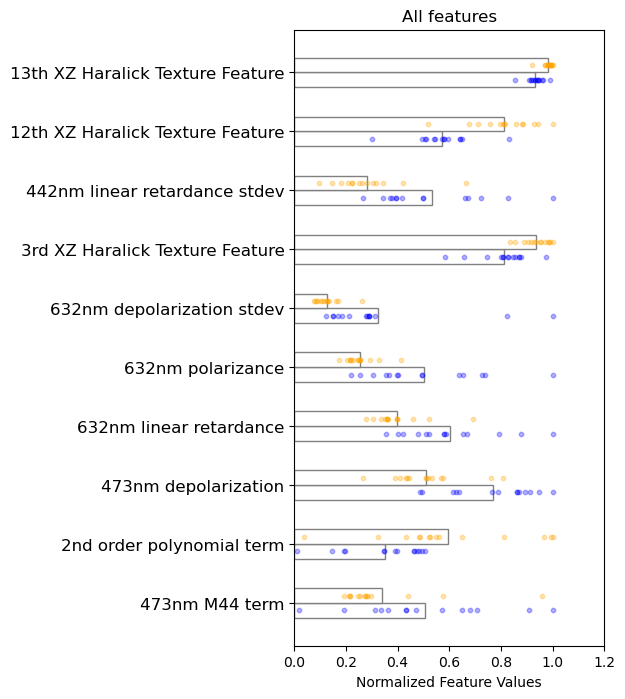

()

In [257]:
data=Sort_From_Index(Best10Ind[::-1],masterfile)
featbarchart(data, "All")

In [258]:
print(Best10Ind)

[47, 46, 78, 42, 90, 74, 53, 62, 25, 121]


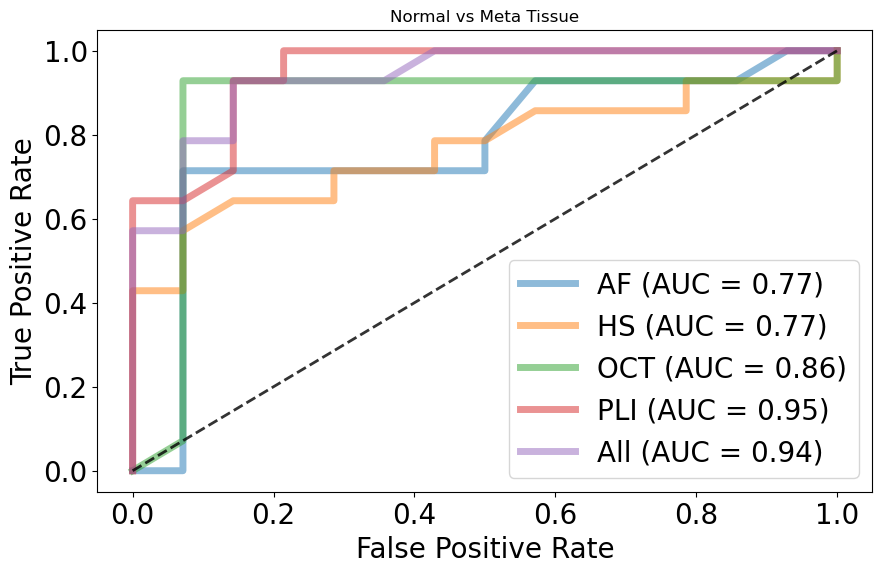

()

In [259]:
#Changing up the ROC curves for suplementary fig-

def RocForAll(AFlist, HSlist, OCTlist, PLIlist, ALLlist, titlestr):
    AFfpr,AFtpr,AFroc_auc=AFlist
    HSfpr,HStpr,HSroc_auc=HSlist
    OCTfpr, OCTtpr, OCTroc_auc= OCTlist
    PLIfpr, PLItpr, PLIroc_auc= PLIlist
    ALLfpr, ALLtpr, ALLroc_auc= ALLlist
    
    plt.figure(1, figsize=(10,6))
    plt.plot(AFfpr,AFtpr, lw=5, alpha=0.5, label='AF (AUC = %0.2f)' % (AFroc_auc))
    plt.plot(HSfpr,HStpr, lw=5, alpha=0.5, label='HS (AUC = %0.2f)' % (HSroc_auc))
    plt.plot(OCTfpr, OCTtpr, lw=5, alpha=0.5, label='OCT (AUC = %0.2f)' % (OCTroc_auc))
    plt.plot(PLIfpr, PLItpr, lw=5, alpha=0.5, label='PLI (AUC = %0.2f)' % (PLIroc_auc))
    plt.plot(ALLfpr, ALLtpr, lw=5, alpha=0.5, label='All (AUC = %0.2f)' % (ALLroc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(titlestr)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.legend(loc="lower right", fontsize=20)
    plt.show()
    
    return()


#All 5 in one?

RocForAll(AFRF10, HSRF10, OCTRF10, PLIRF10,AllRF10, "Normal vs Meta Tissue")